# Evaluating Tikhonet Trained

In this Notebook we are going to evaluate the performance of a [Tikhonet](https://arxiv.org/pdf/1911.00443.pdf) trained.

## Required Libraries and Functions

In [1]:
%matplotlib inline
import sys

# Add library path to PYTHONPATH
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)
data_path = '/gpfswork/rech/xdy/uze68md/data/'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_cfht/'

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import cadmos_lib as cl
import tensorflow as tf
import galsim
from galsim import Image
import galsim.hsm
import pickle

## Load The Comparison Batch

In [2]:
f = open(data_path+"cfht_batch.pkl", "rb")
batch = pickle.load(f)
f.close()

#correct tikhonov inputs normalisation factor
norm_factor = 4e3
batch['inputs_tikho'] *= norm_factor

## Load and Apply Trained Model on Batch

In [3]:
model_name = 'tikhonet_None-constraint_scales-4_steps-625_epochs-10_growth_rate-12_batch_size-128_activationfunction-relu'
# g: gamma (trade-off parameter of the shape constraint)
model_g05_name = 'tikhonet_multi-constraint_scales-4_gamma-0.5_shearlet-3_steps-625_epochs-10_growth_rate-12_batch_size-128_activationfunction-relu'
model = tf.keras.models.load_model(model_dir+model_name, compile=False)
model_g05 = tf.keras.models.load_model(model_dir+model_g05_name, compile=False)
res = model(np.expand_dims(batch['inputs_tikho'], axis=-1))
res_np = tf.keras.backend.eval(res)[...,0]
res_g05 = model_g05(np.expand_dims(batch['inputs_tikho'], axis=-1))
res_g05_np = tf.keras.backend.eval(res_g05)[...,0]
score_g0 = np.load(data_path+'score_g0.npy')
score_g1 = np.load(data_path+'score_g1.npy')

# generate the psfs in the spatial domain
psf_hst = np.fft.ifftshift(np.fft.irfft2(batch['psf_hst'][0]))
psf_tile_cfht = np.array([np.fft.ifftshift(np.fft.irfft2(p)) for p in batch['psf_cfht']])
# make psf tiles
psf_tile_hst = np.repeat(psf_hst[np.newaxis, :, :], batch['psf_hst'].shape[0], axis=0)
# psf_tile_cfht = np.repeat(psf_cfht[np.newaxis, :, :], k_batch*n_batch, axis=0)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Plot Galaxy Images

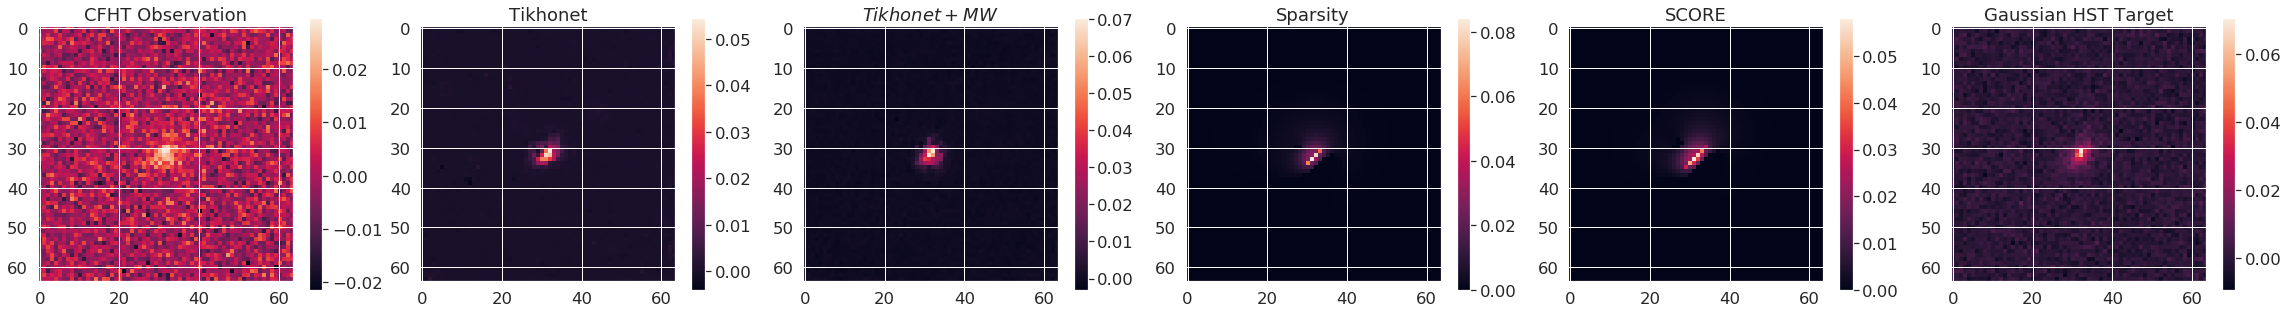

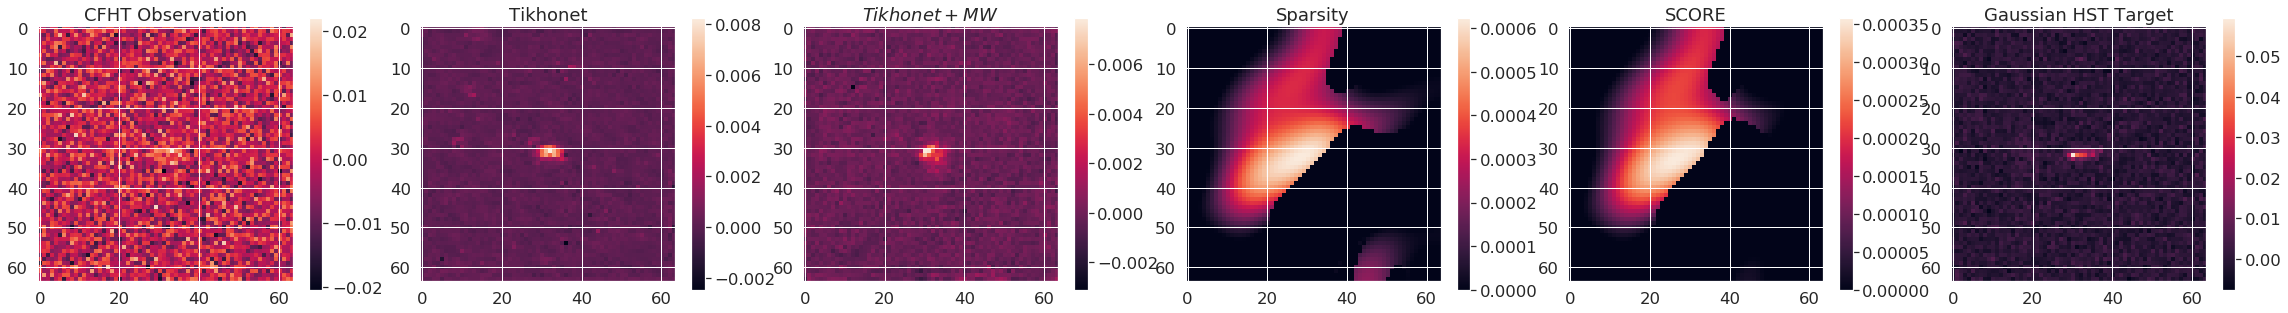

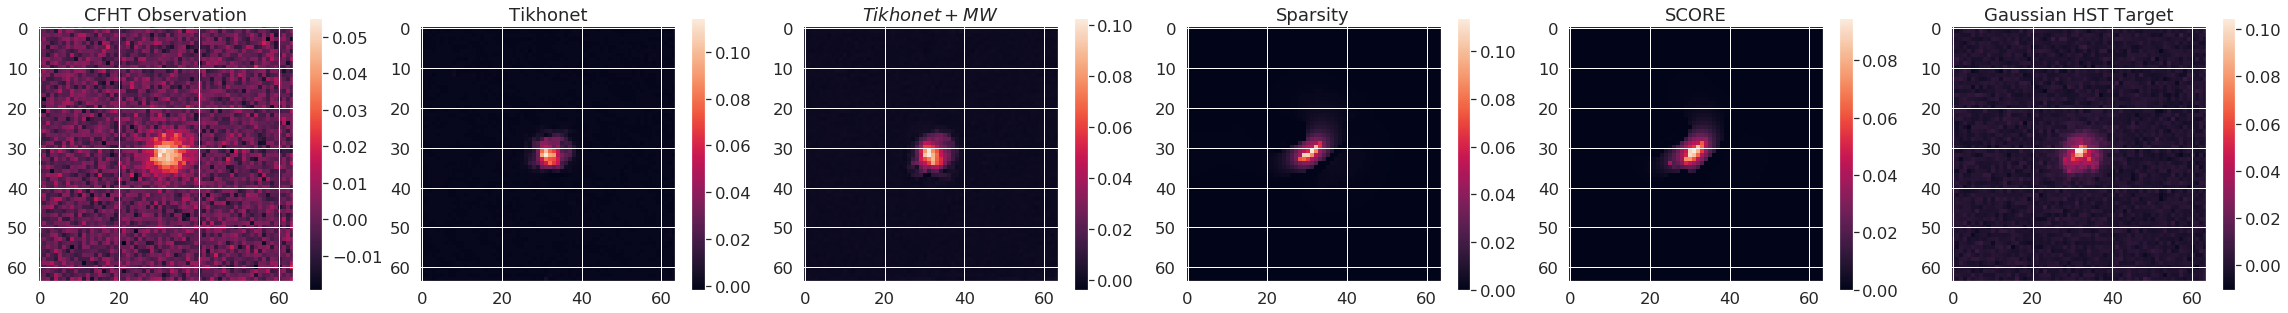

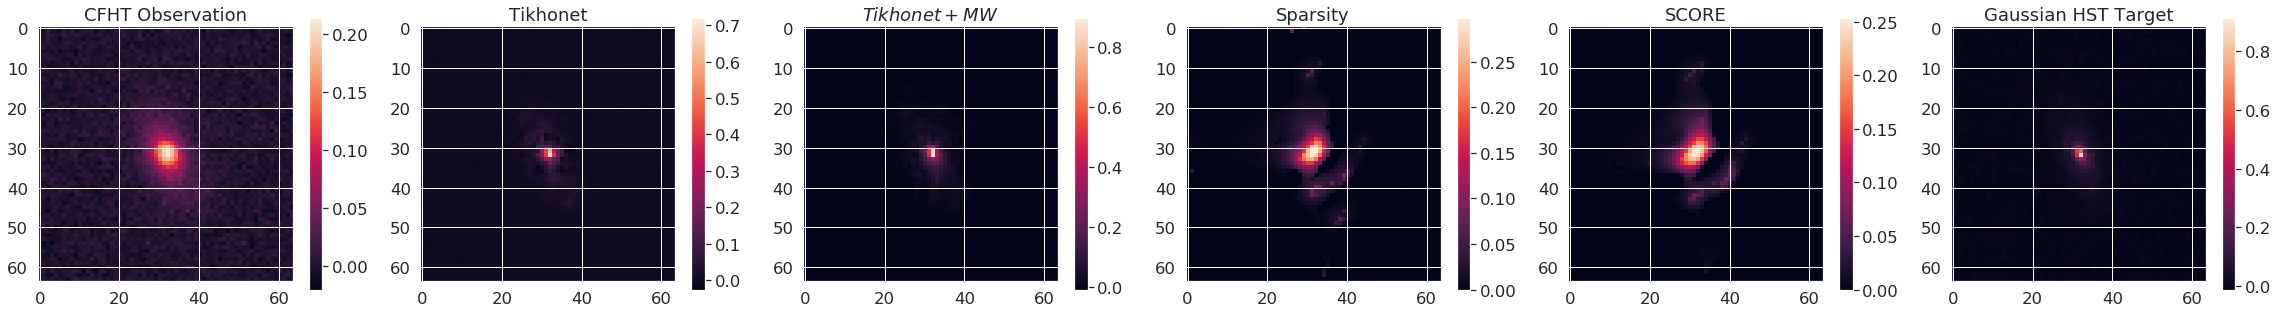

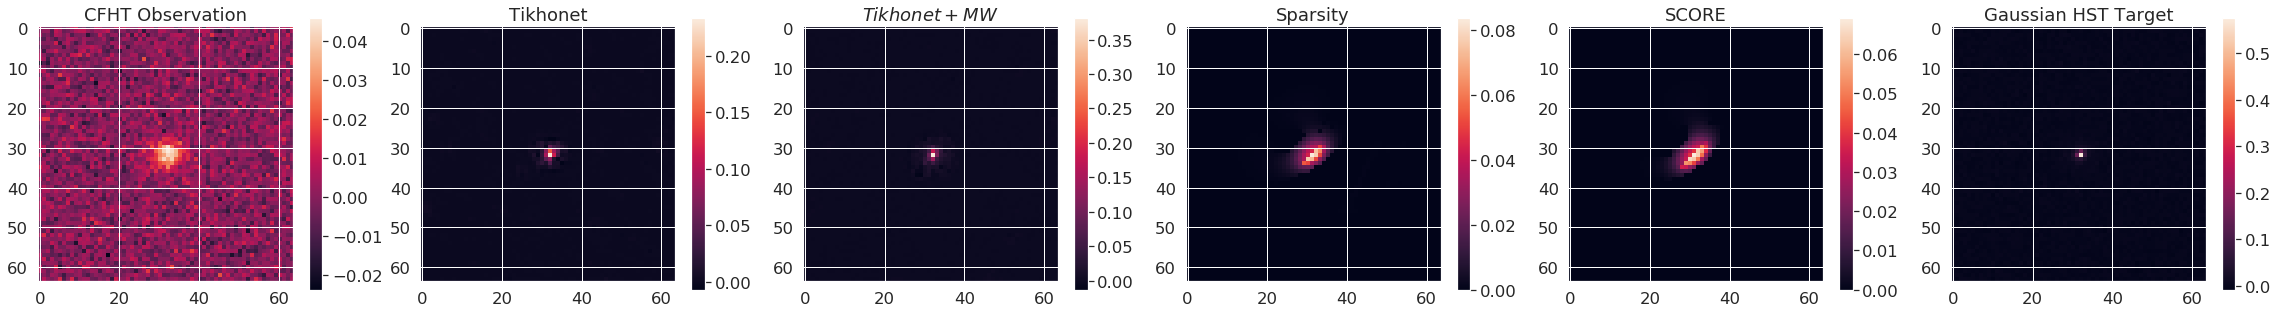

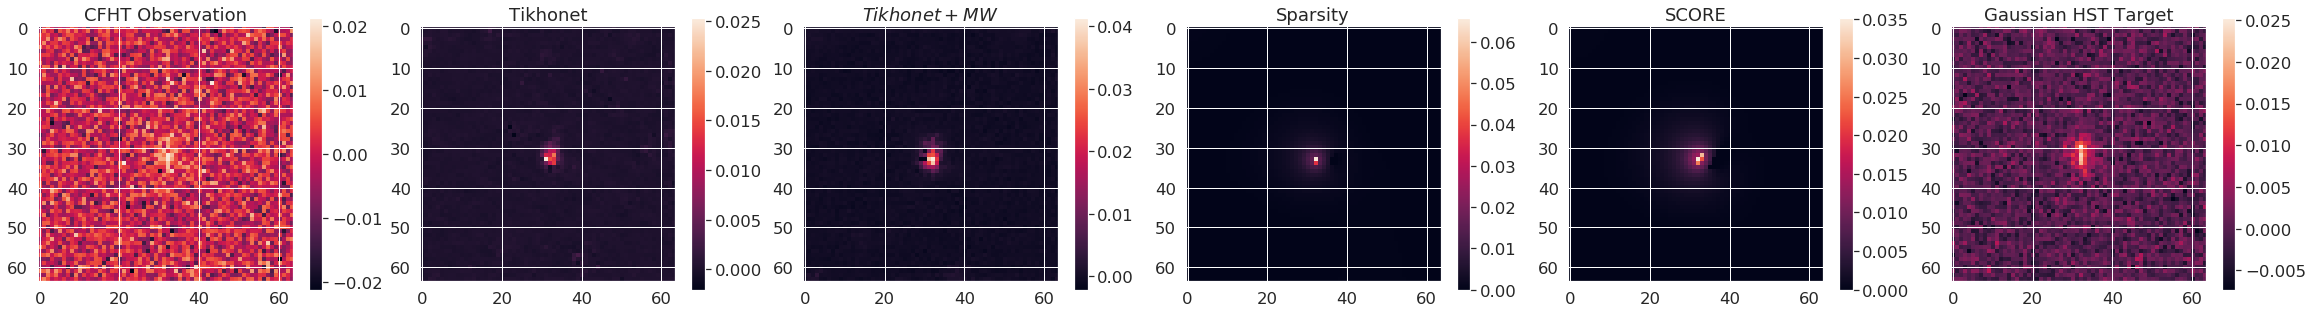

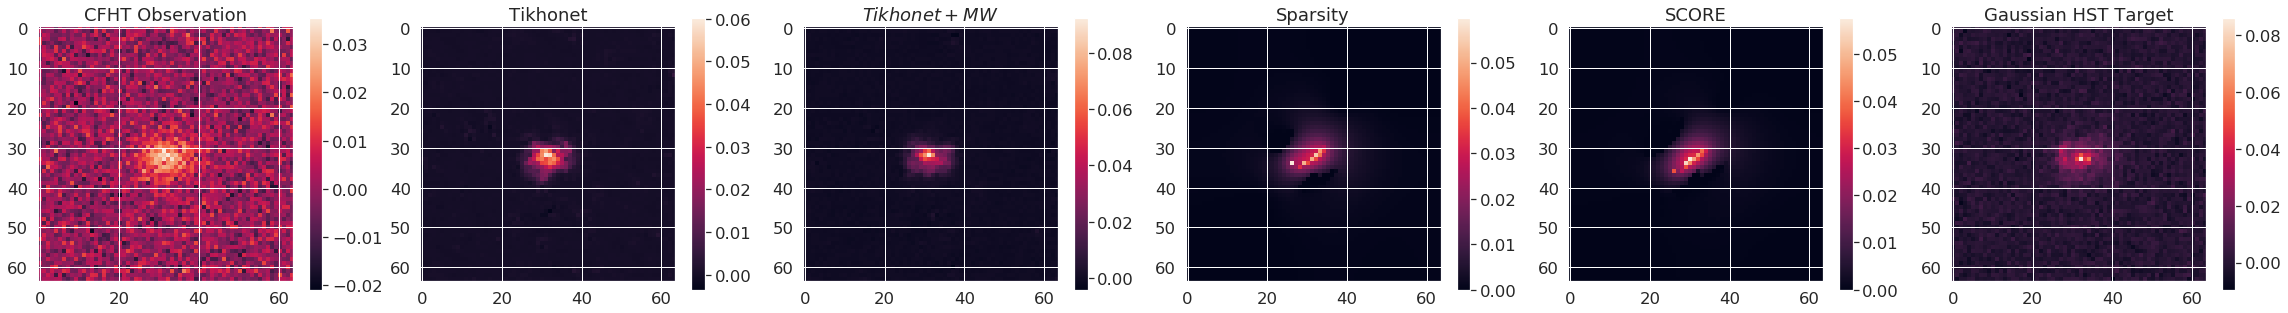

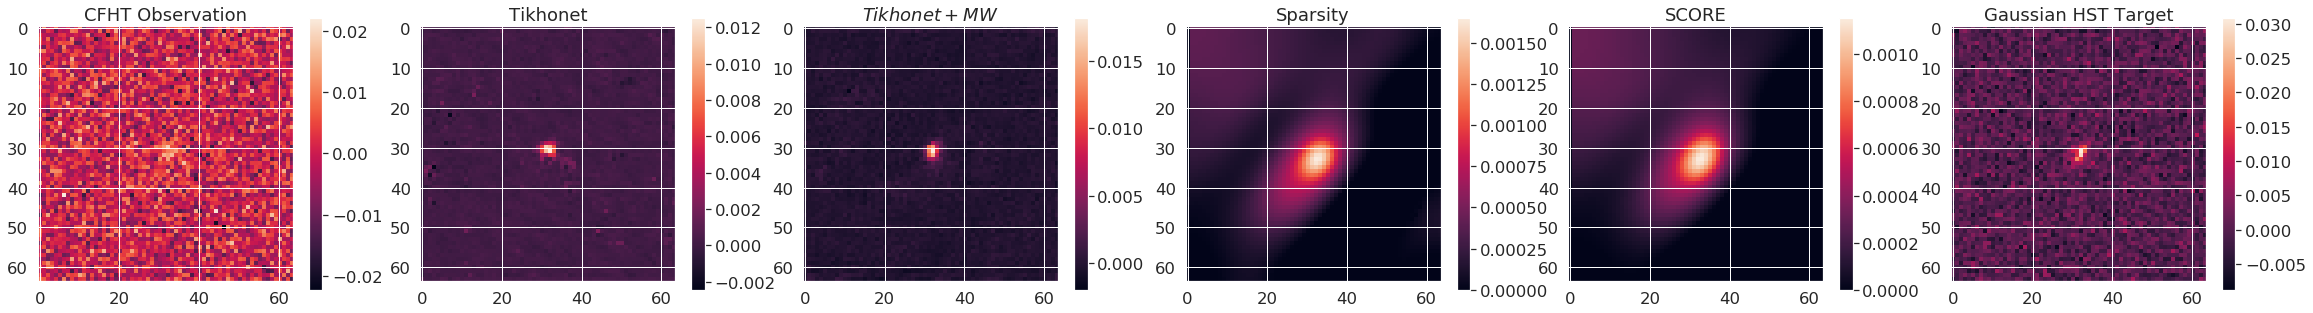

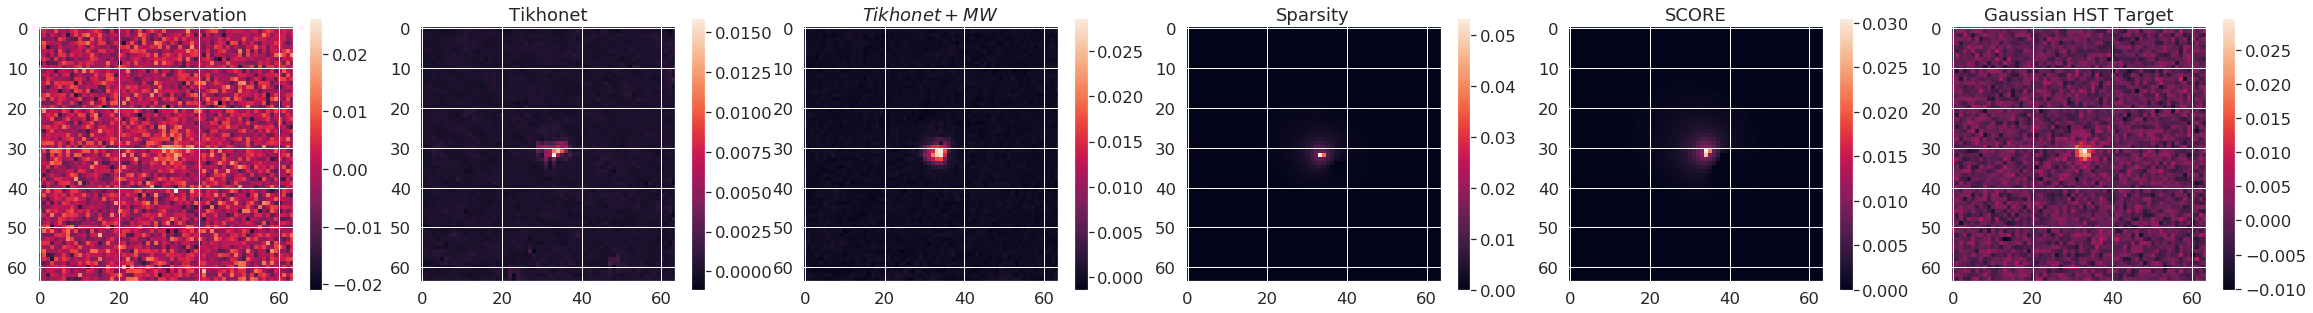

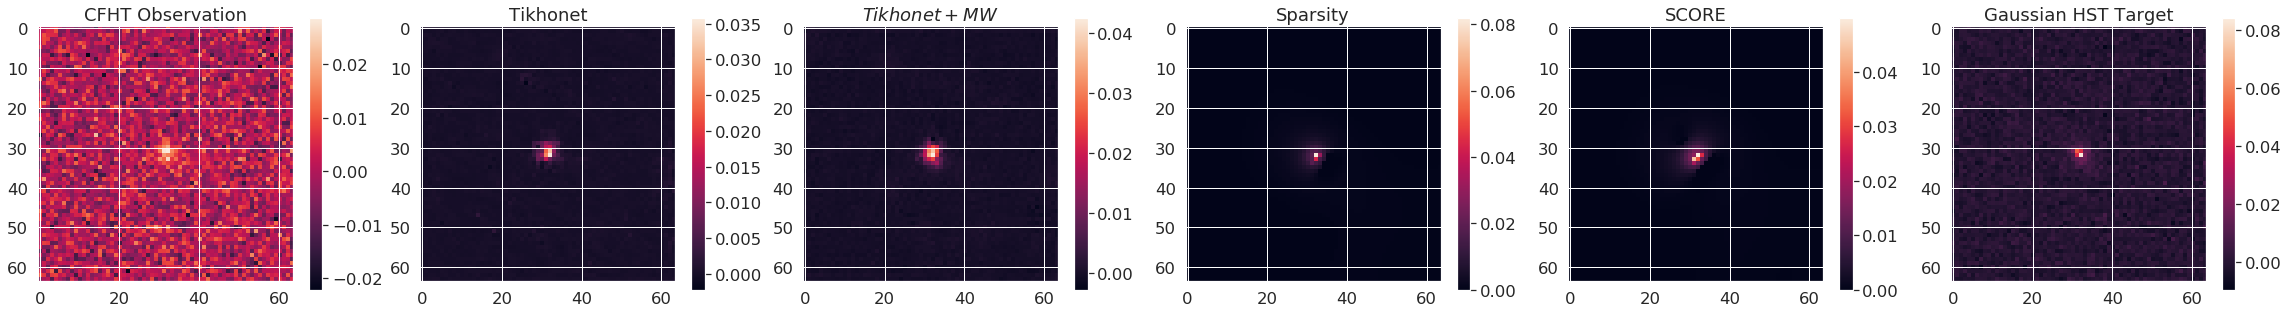

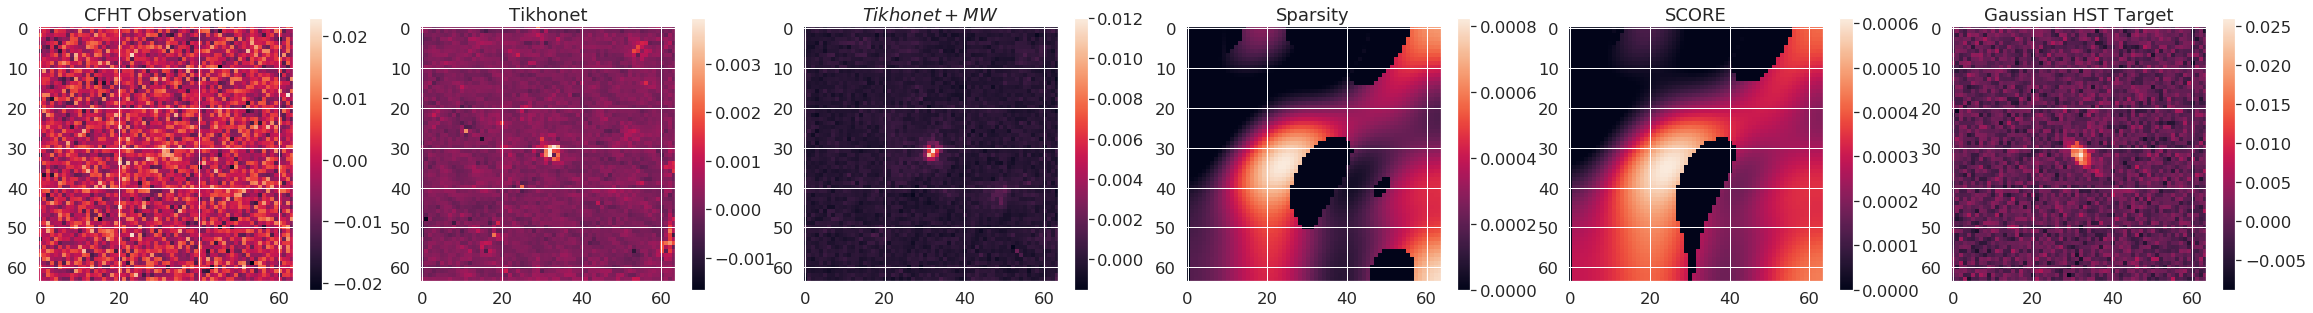

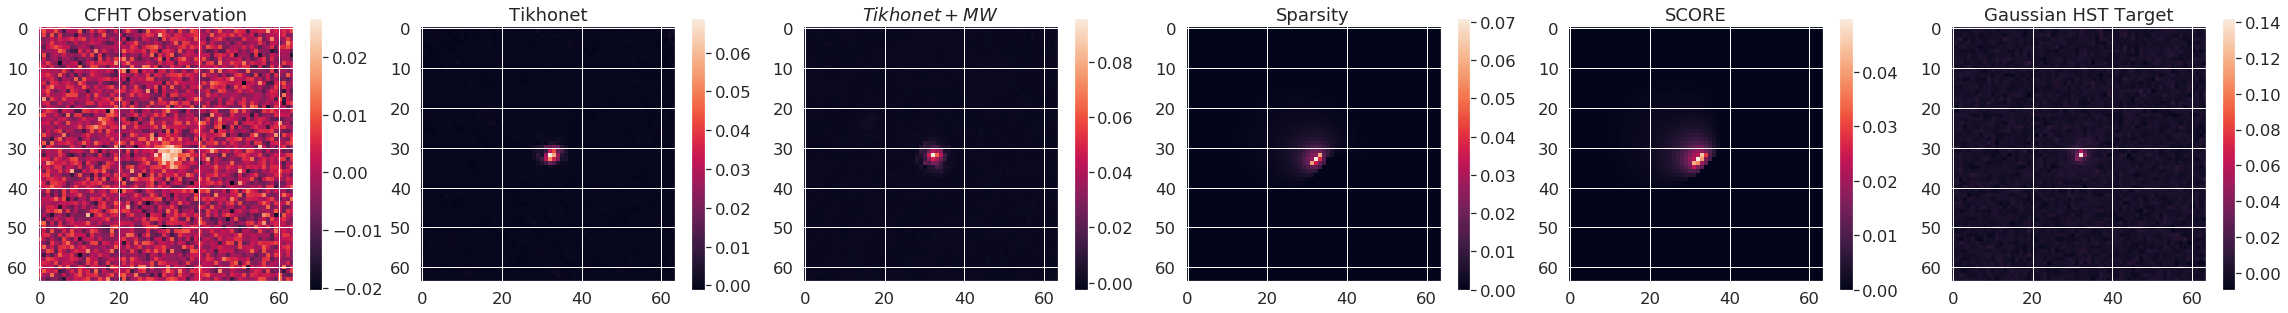

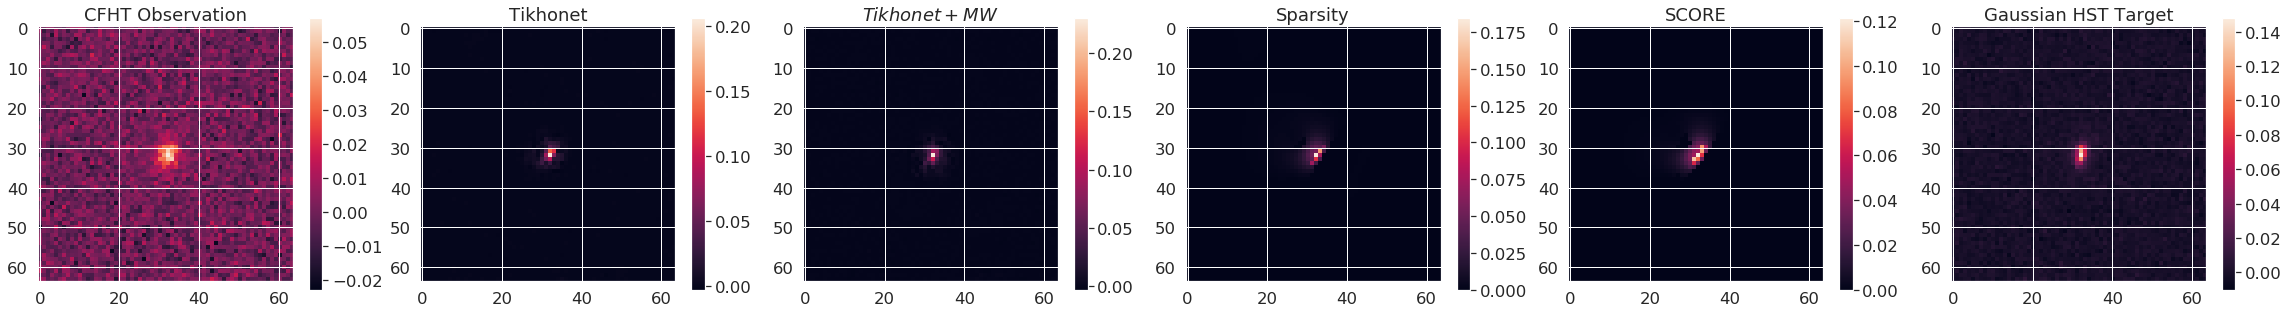

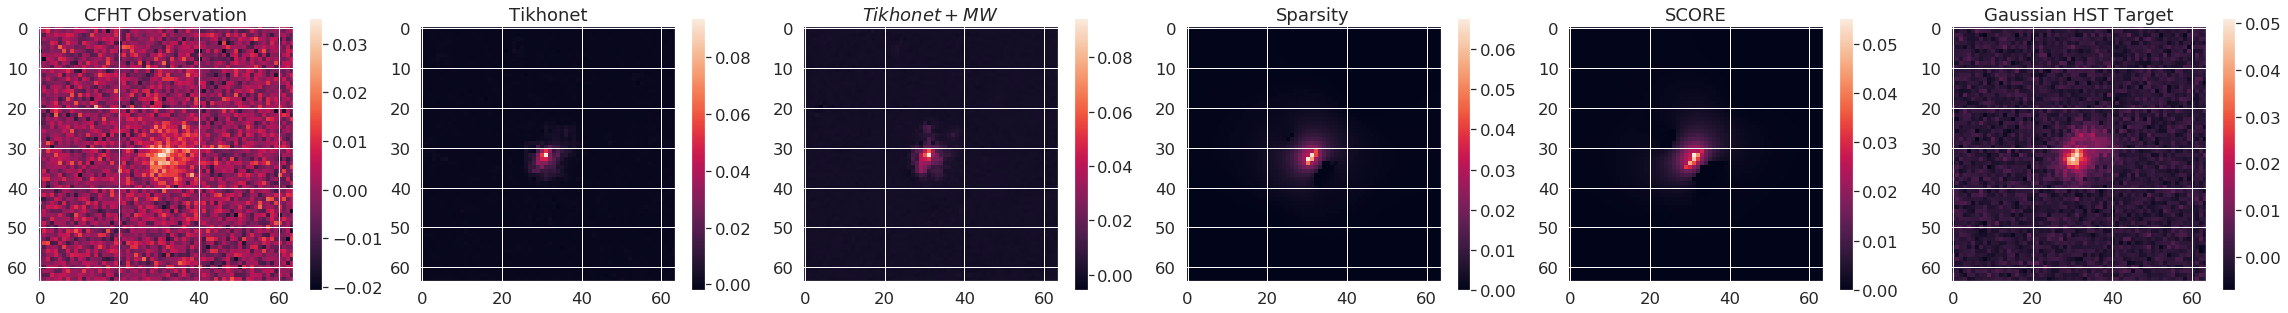

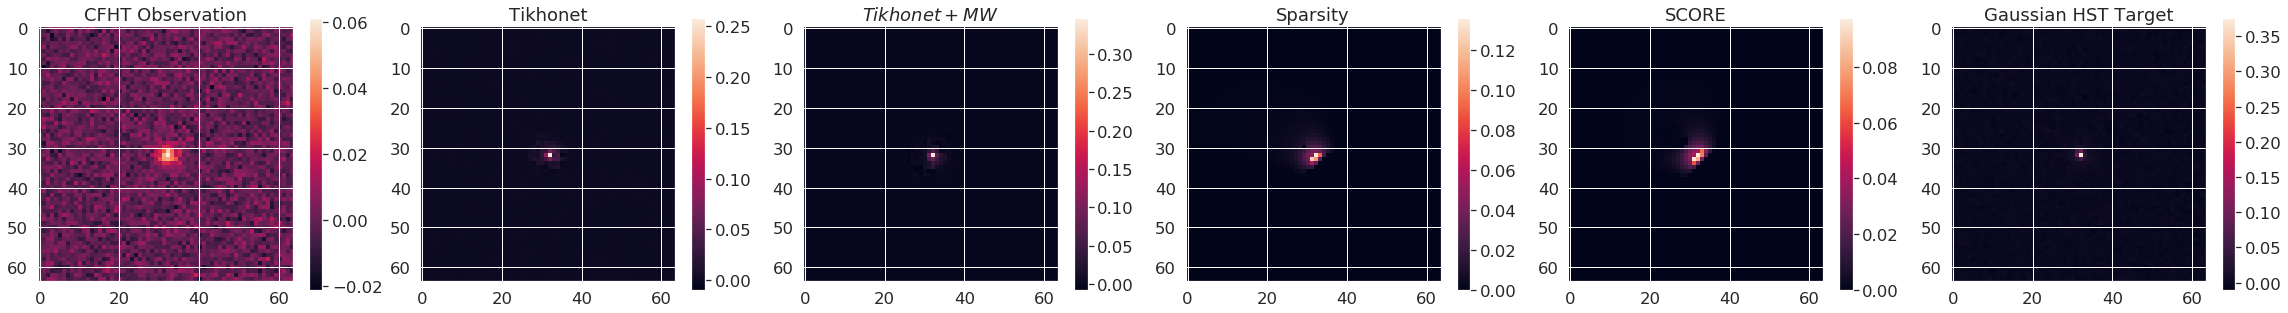

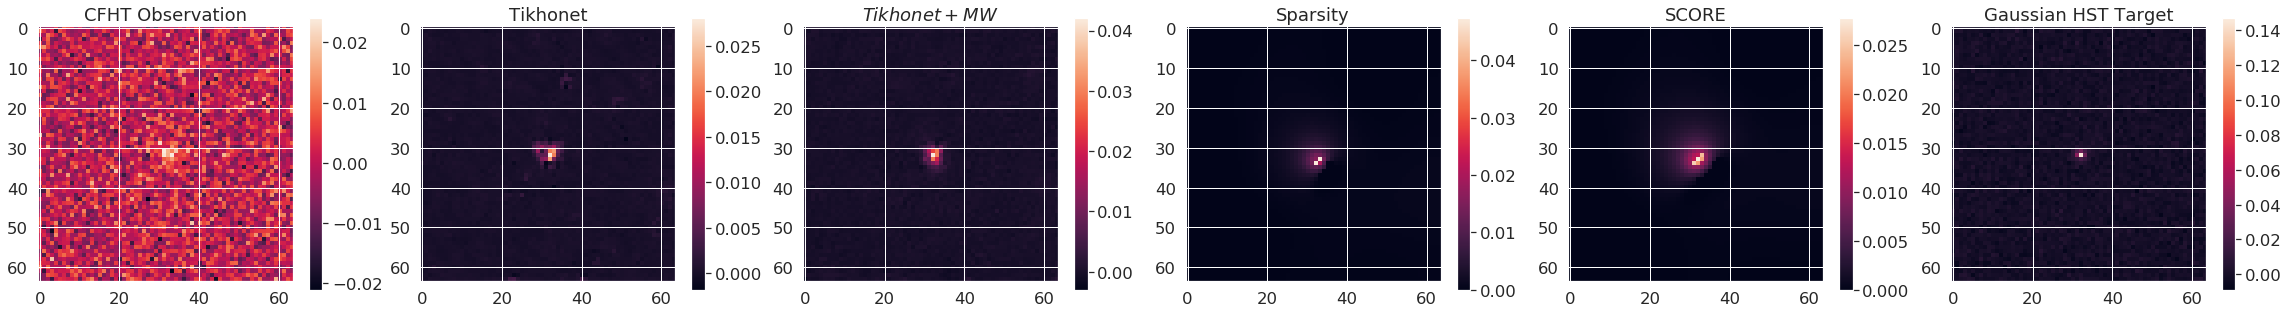

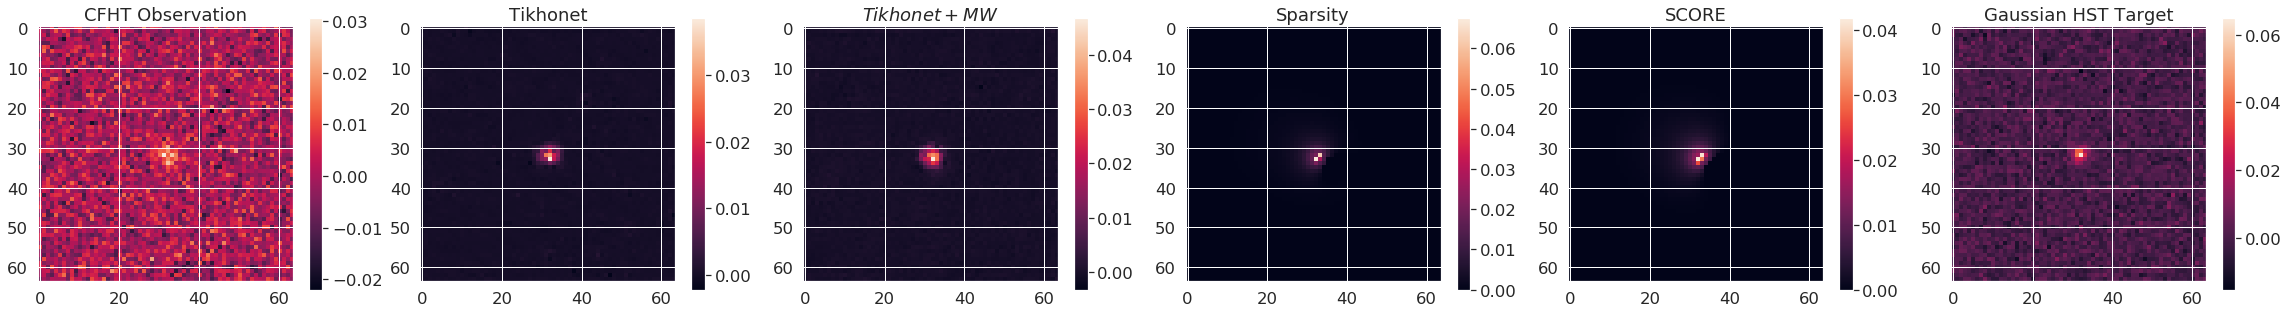

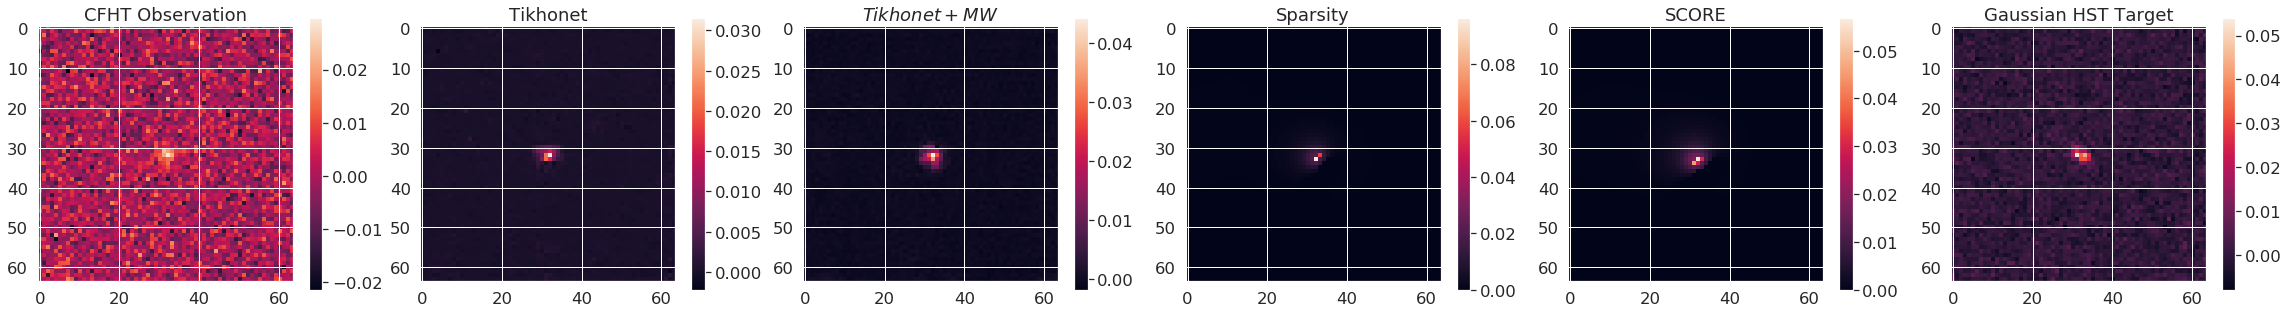

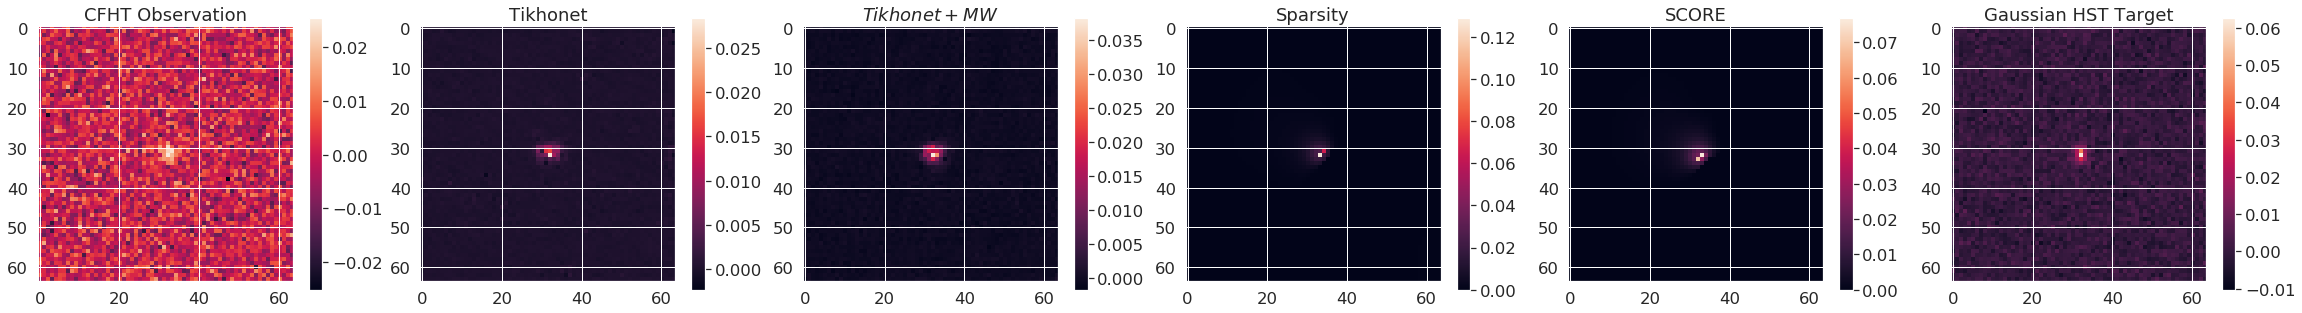

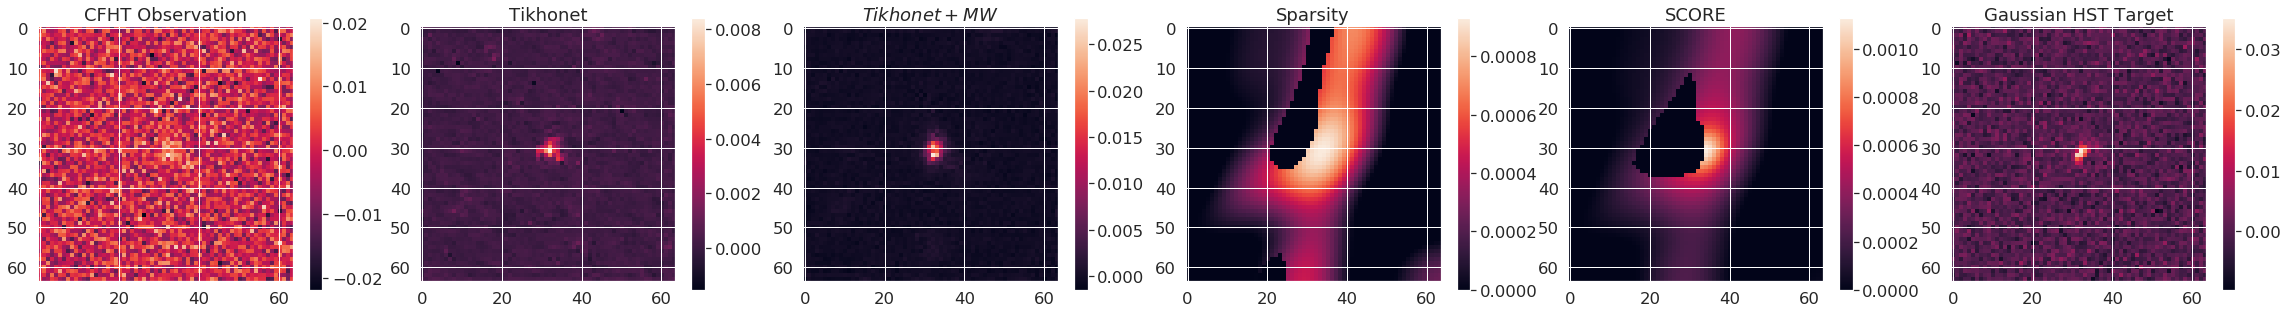

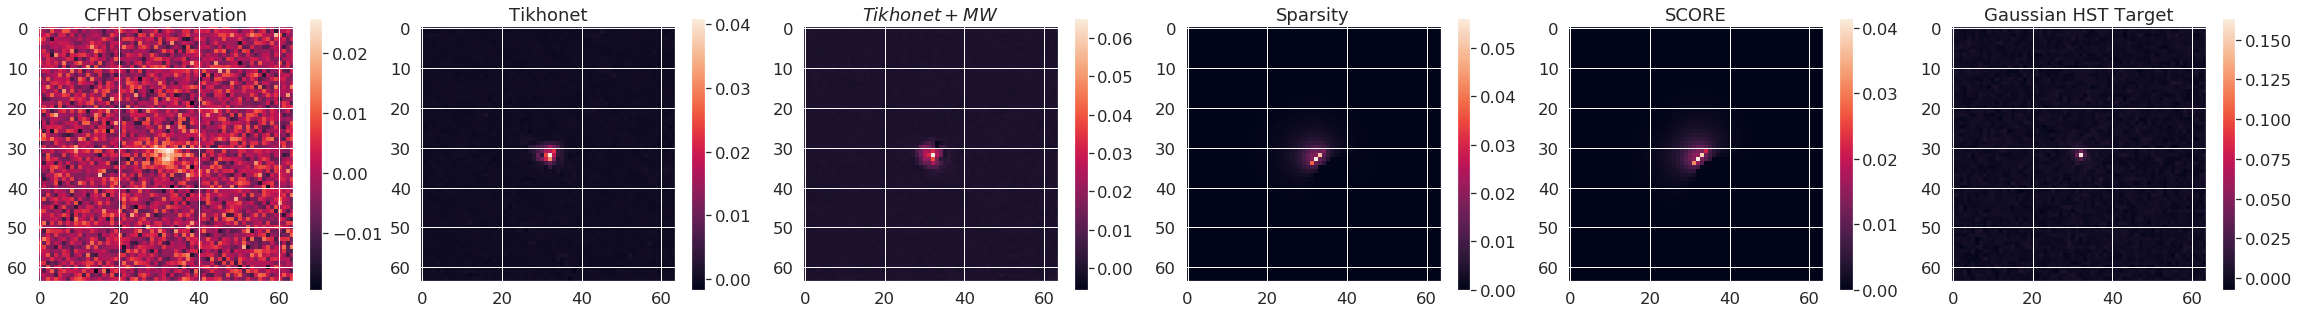

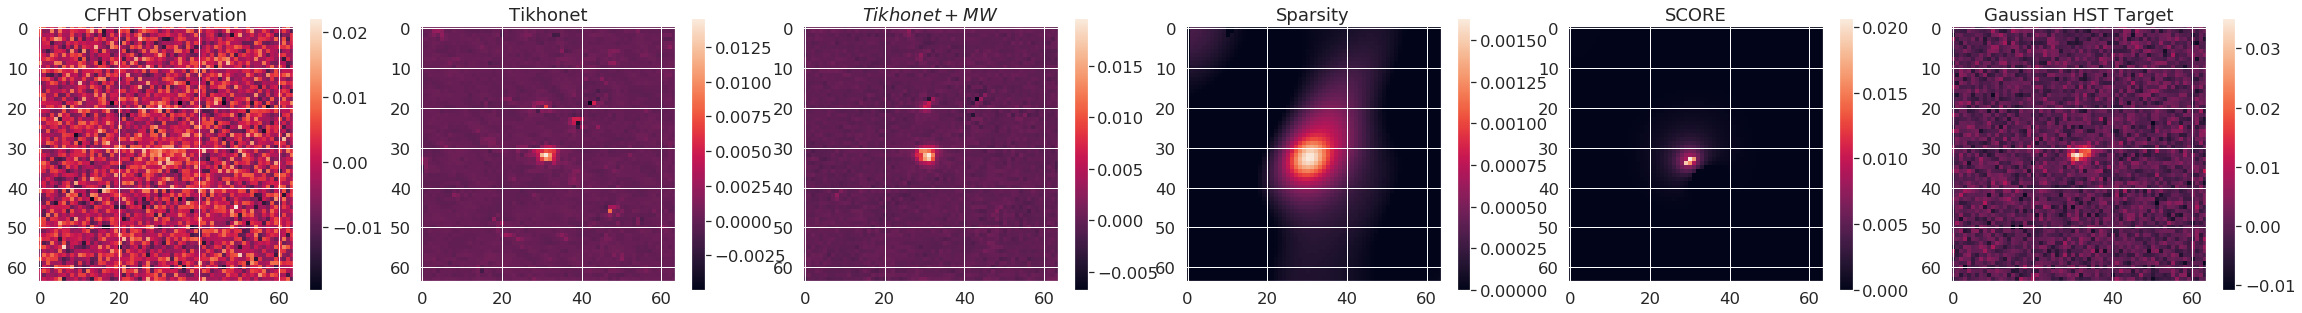

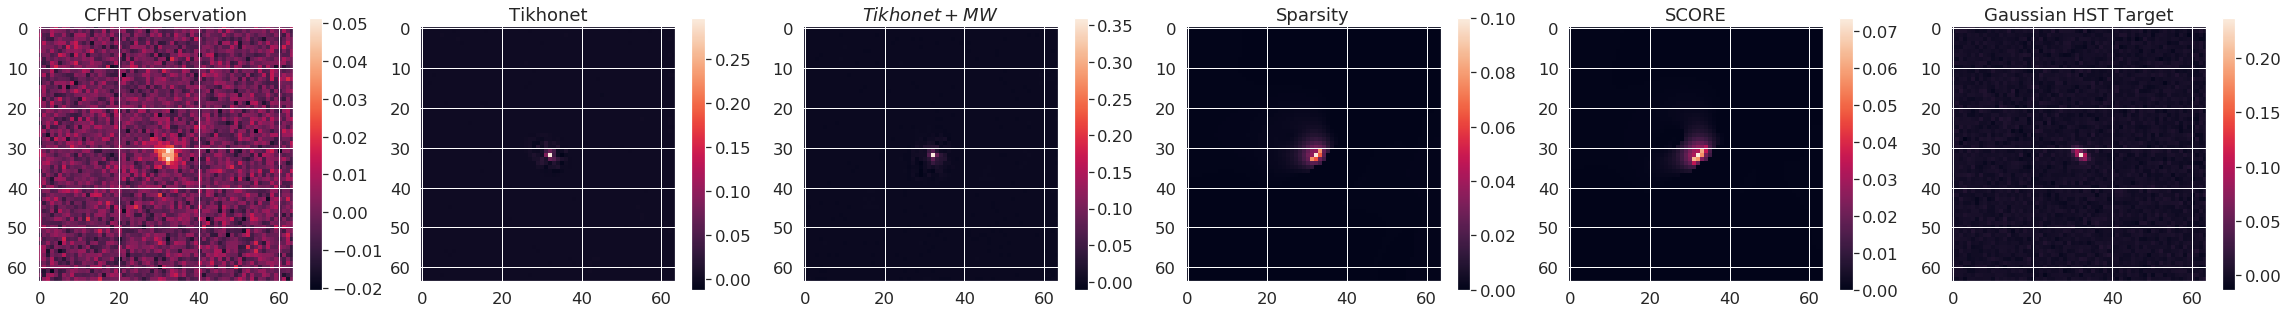

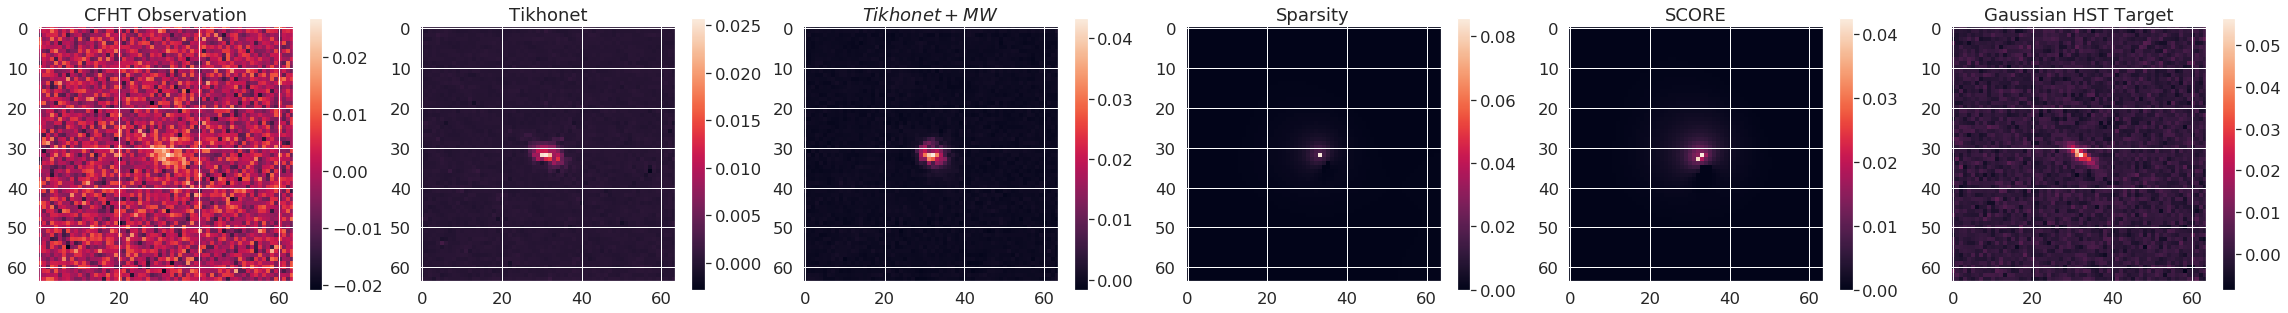

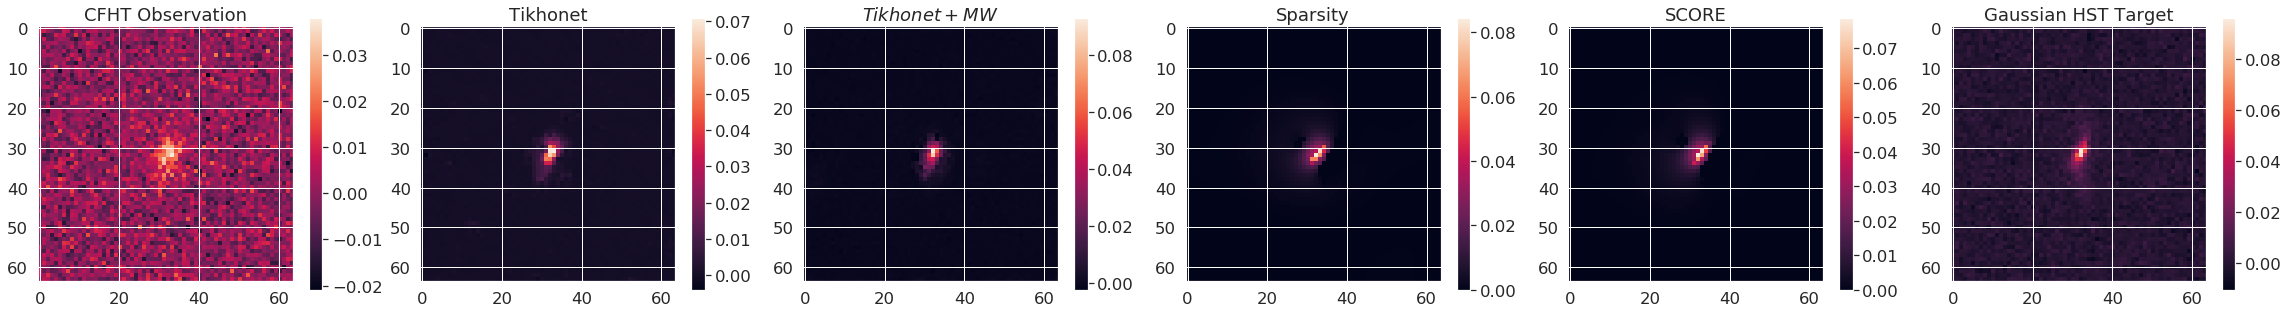

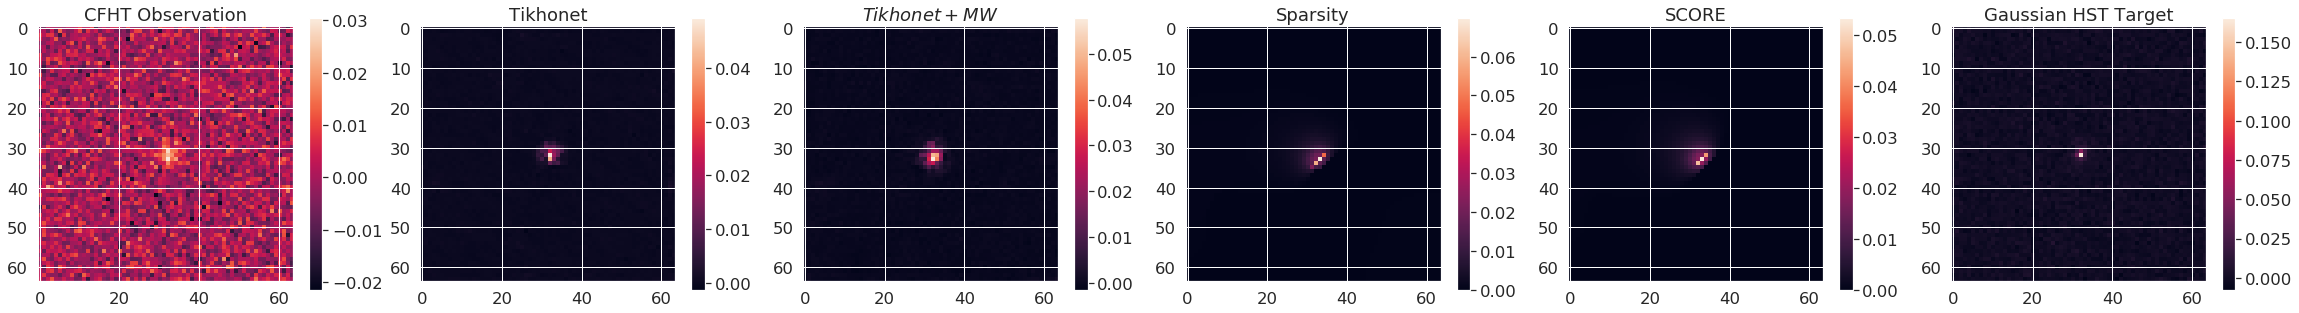

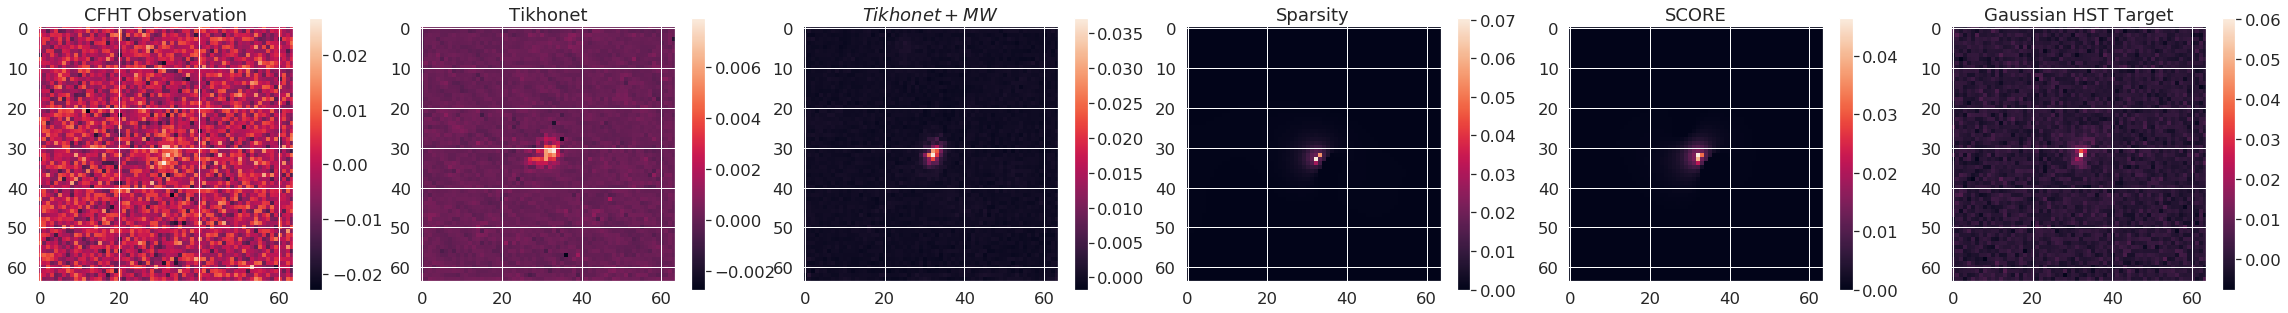

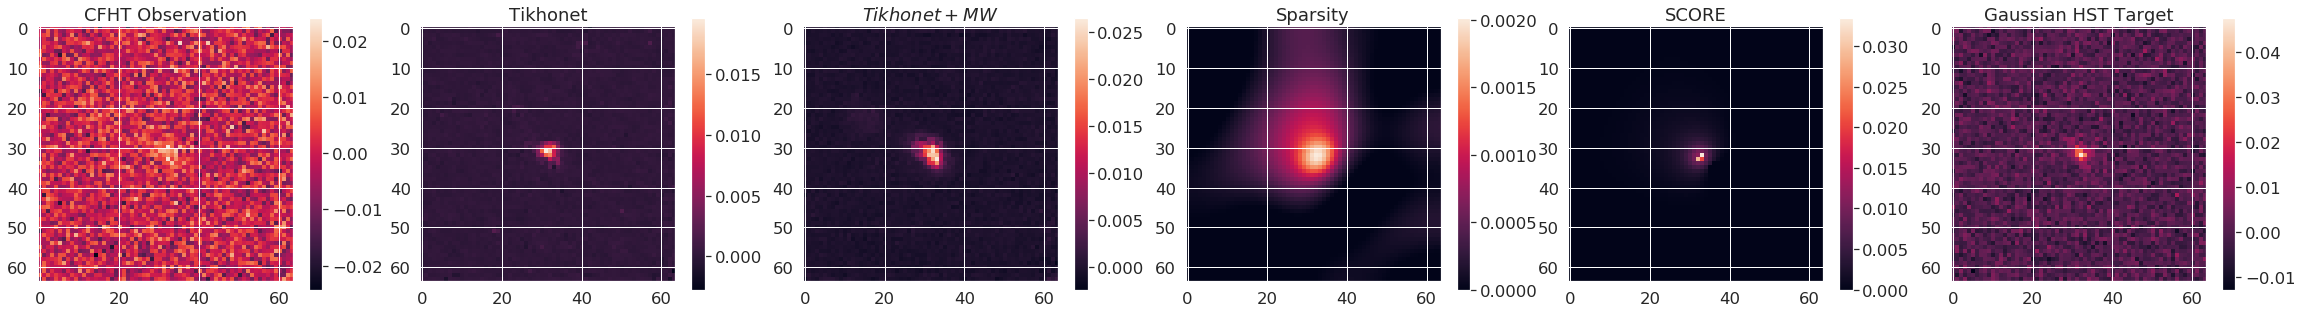

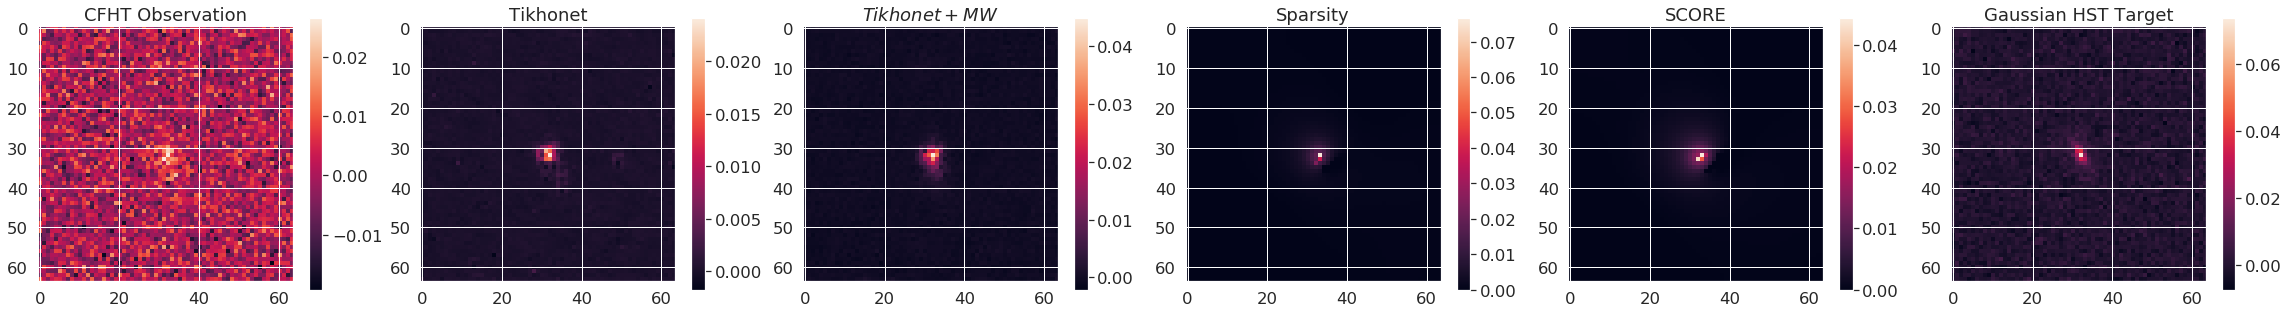

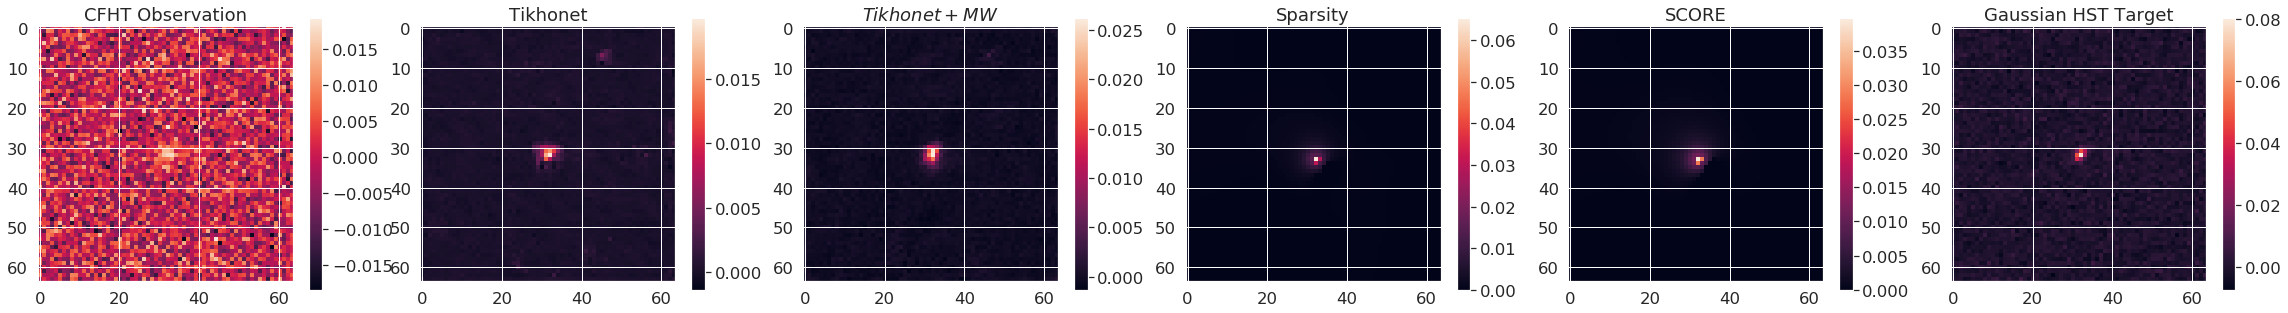

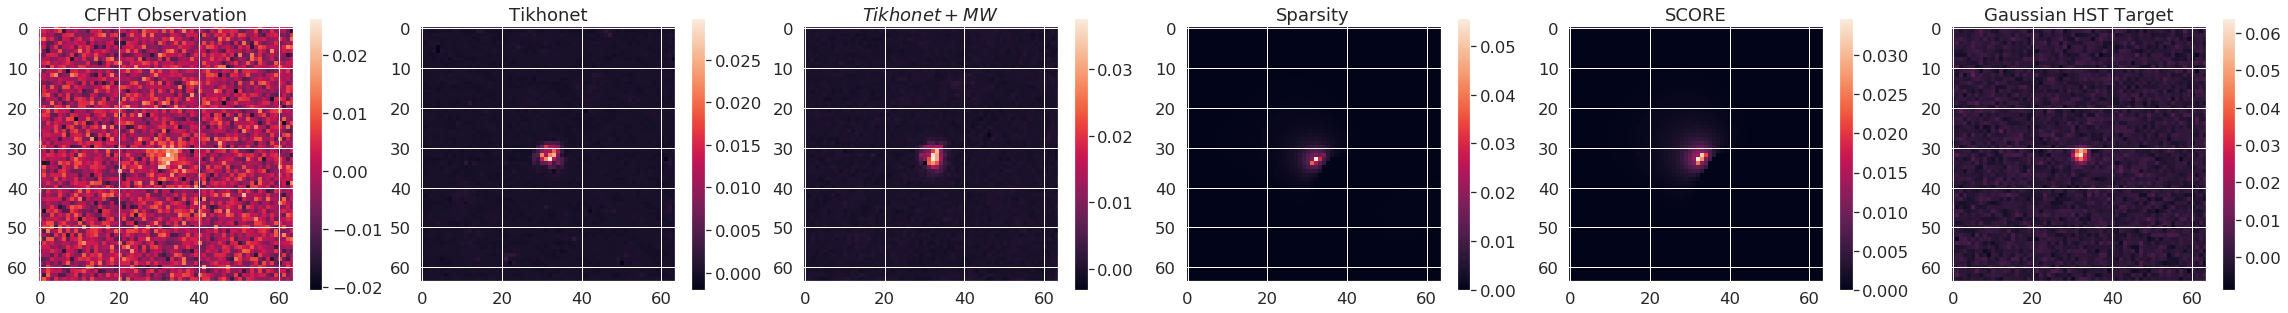

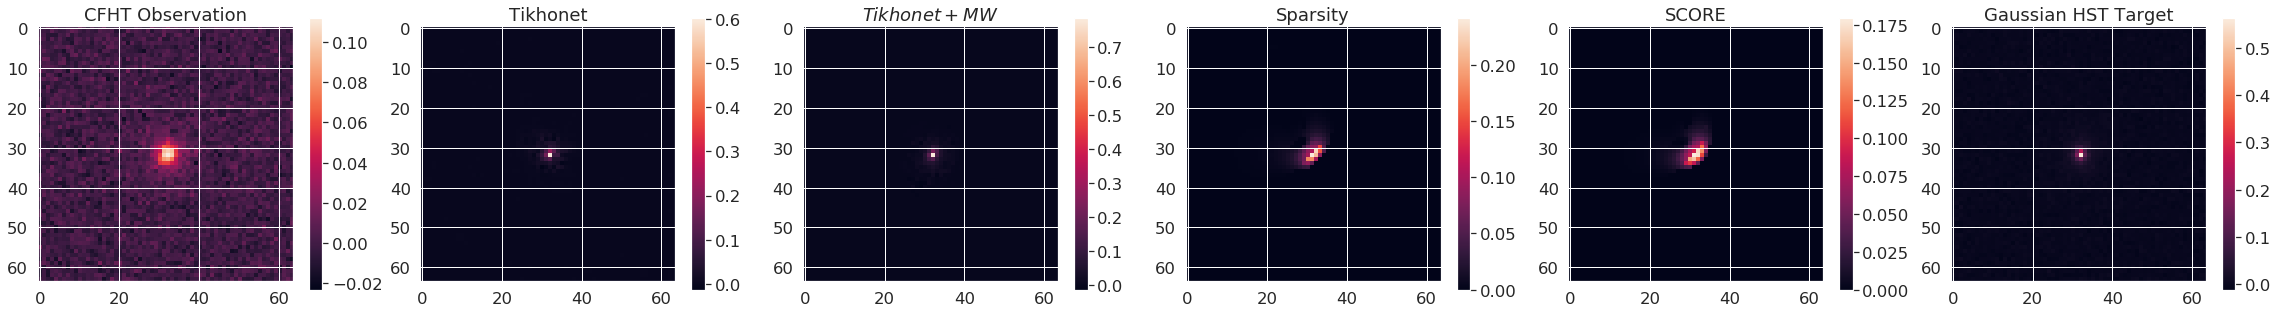

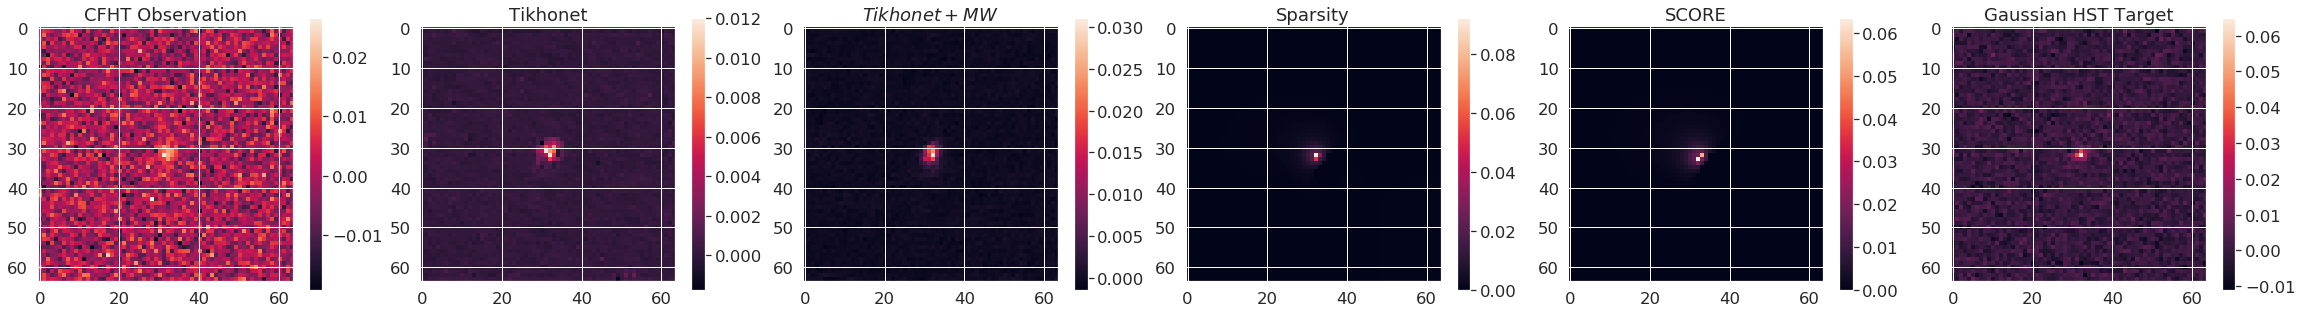

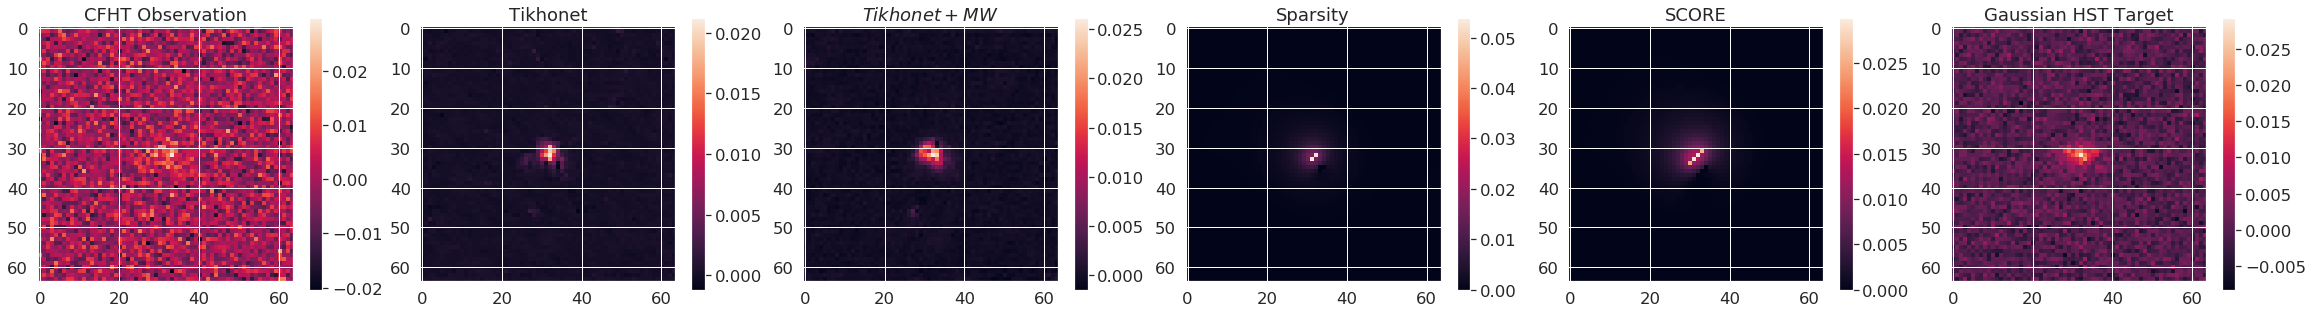

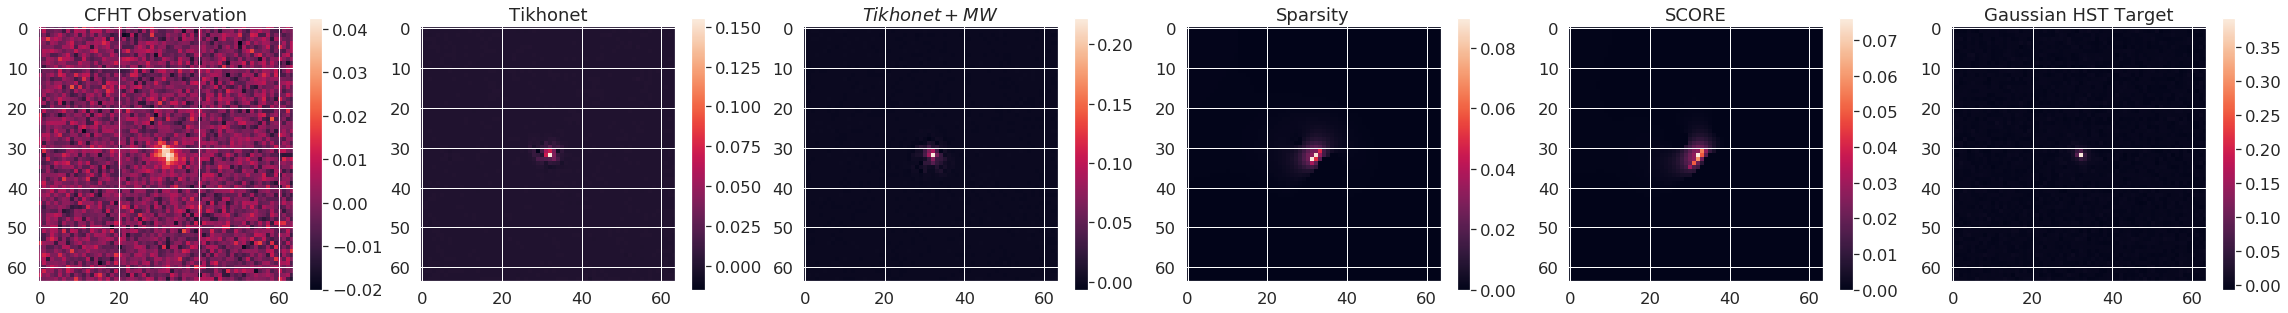

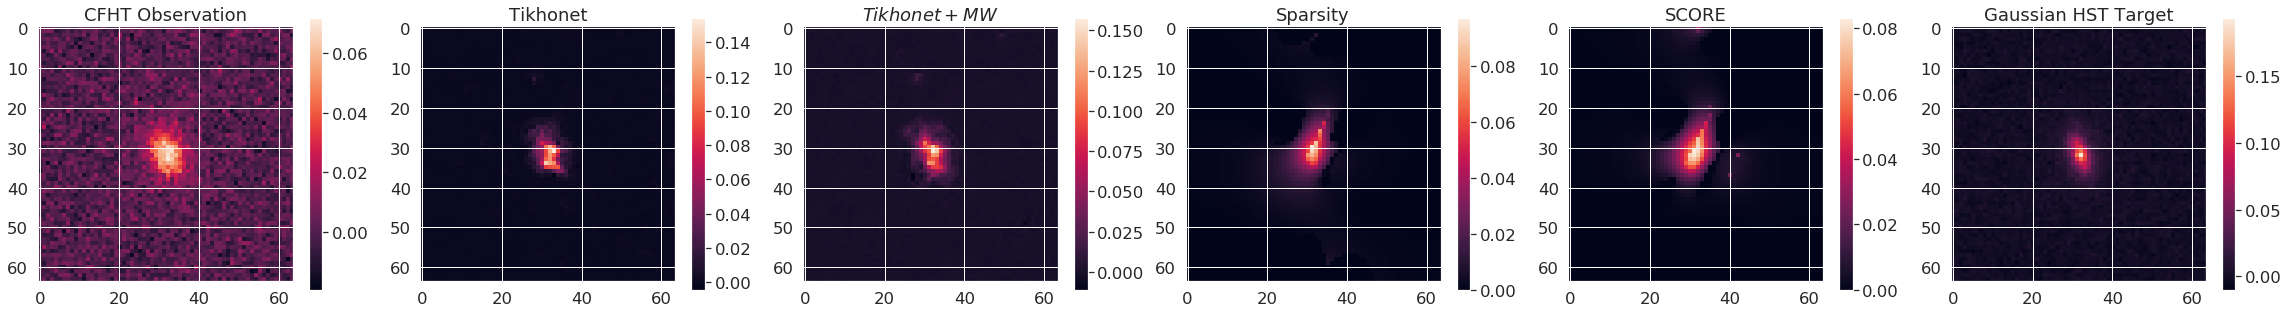

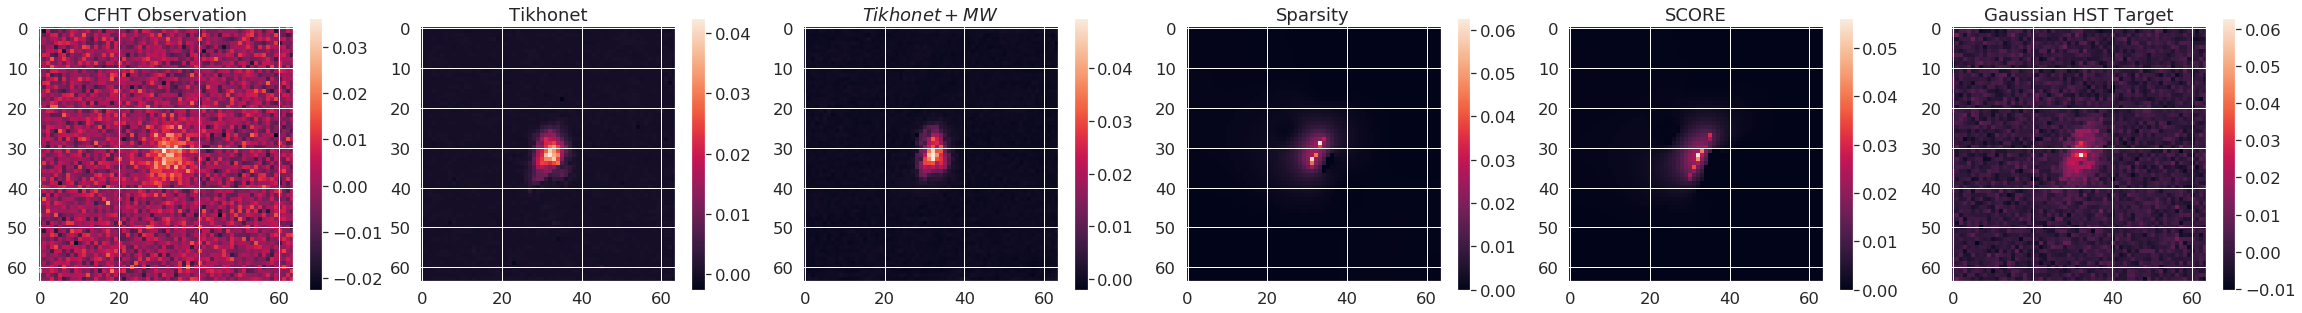

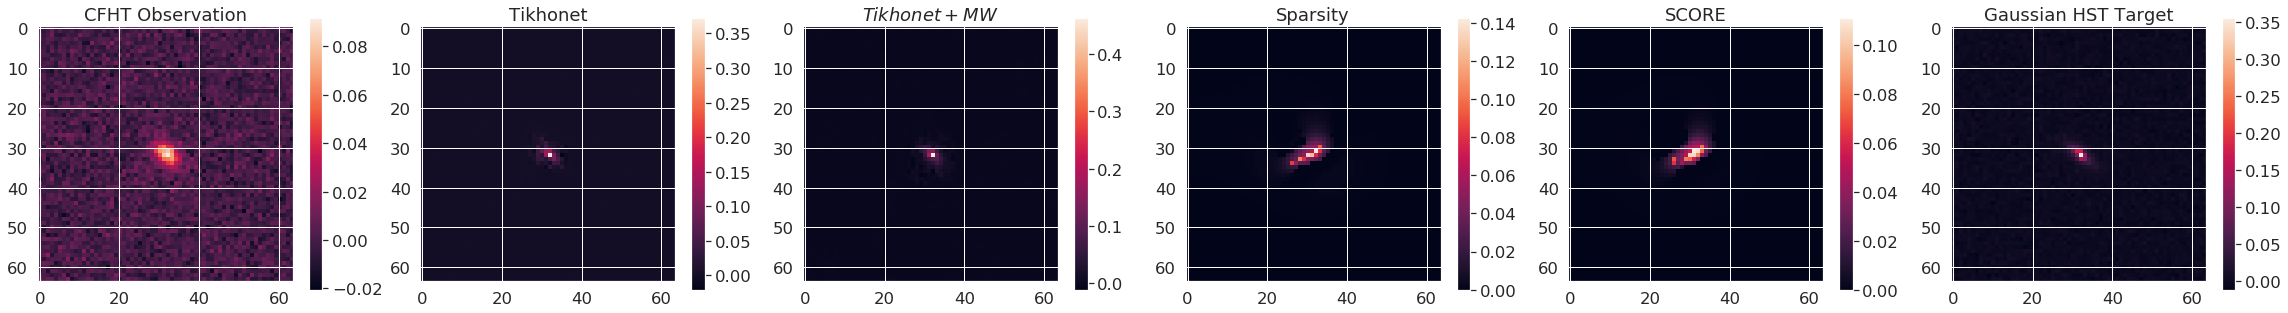

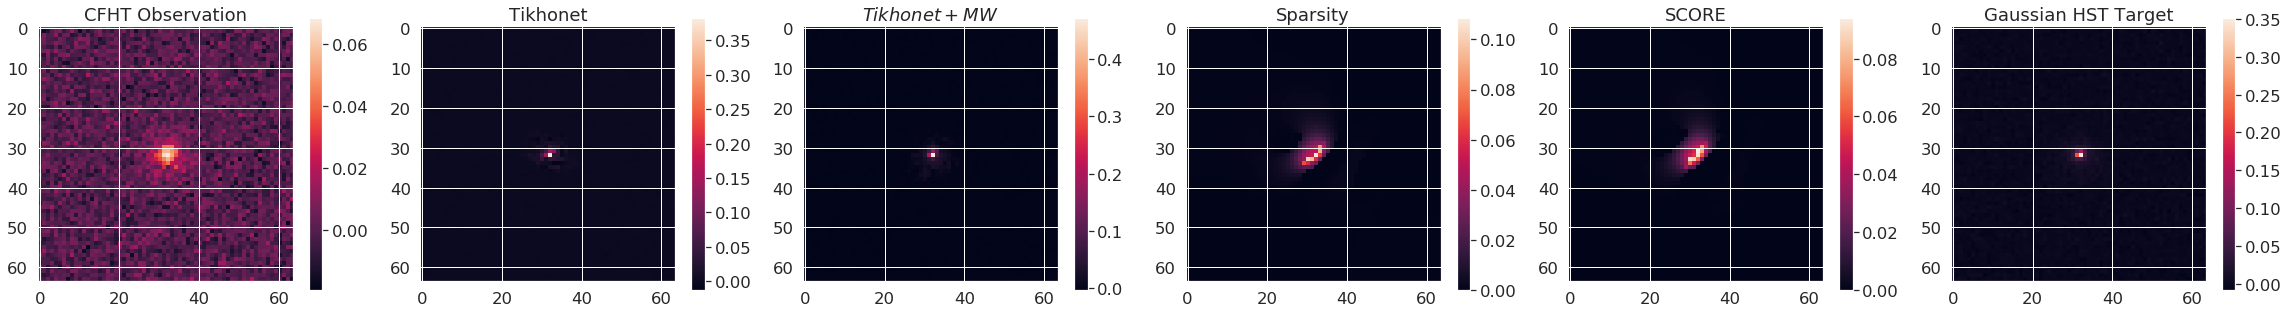

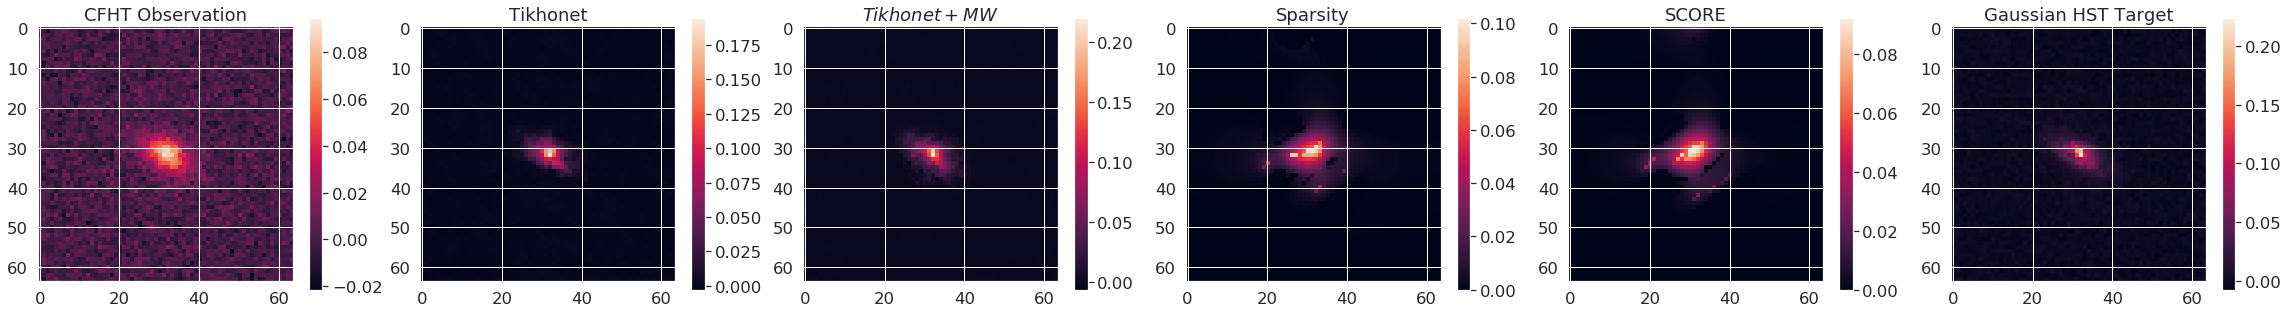

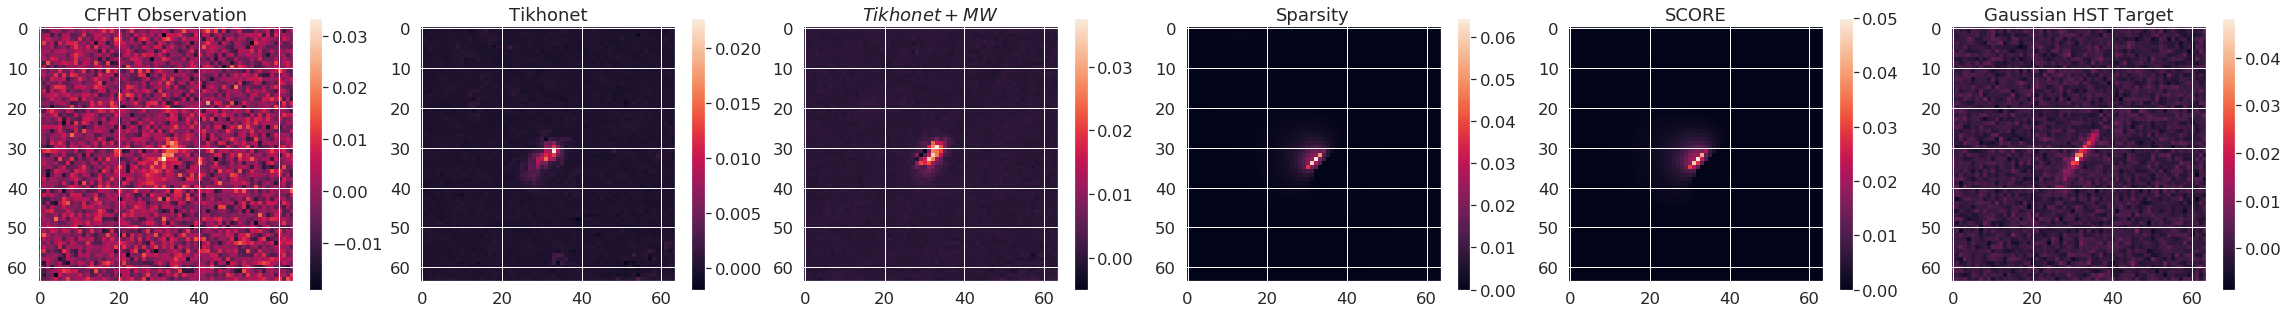

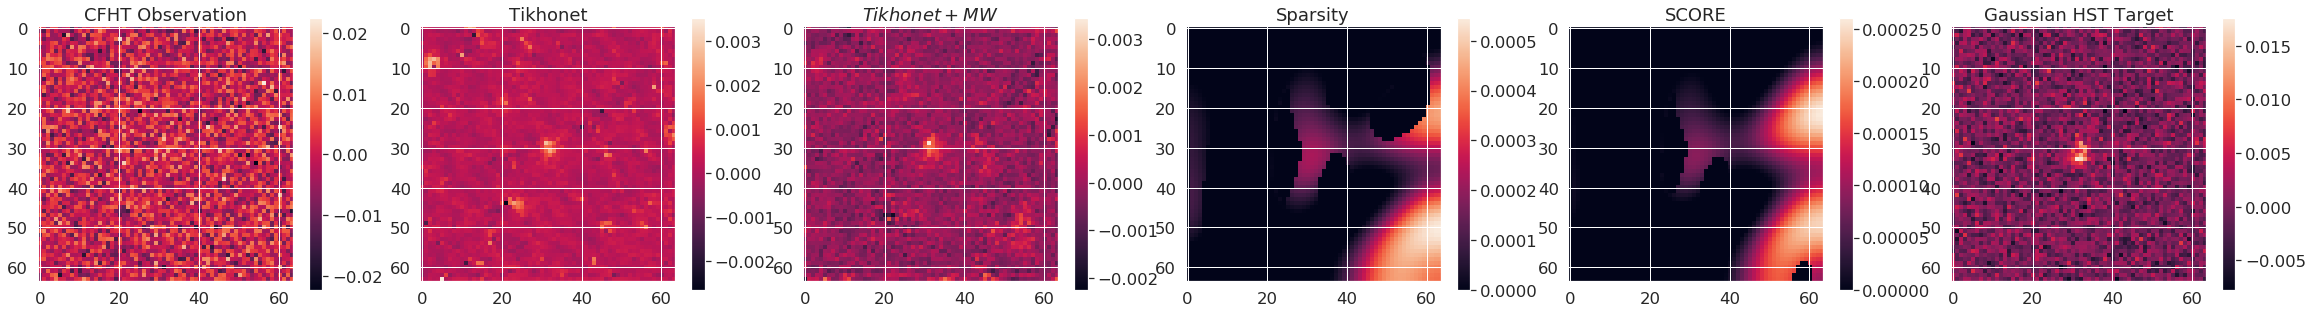

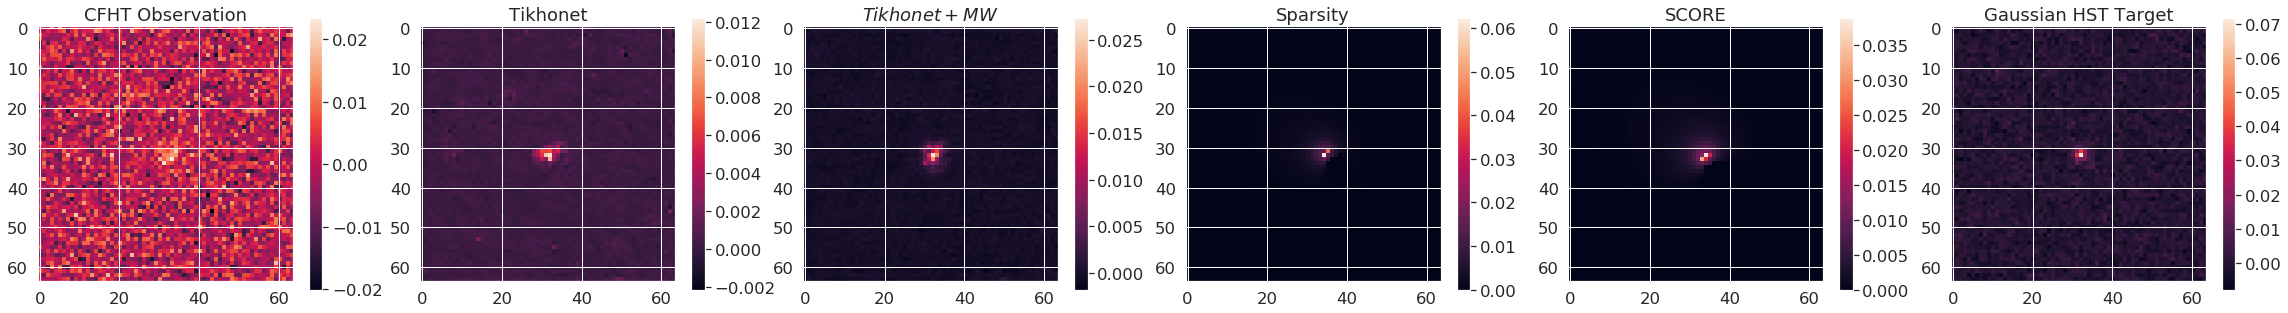

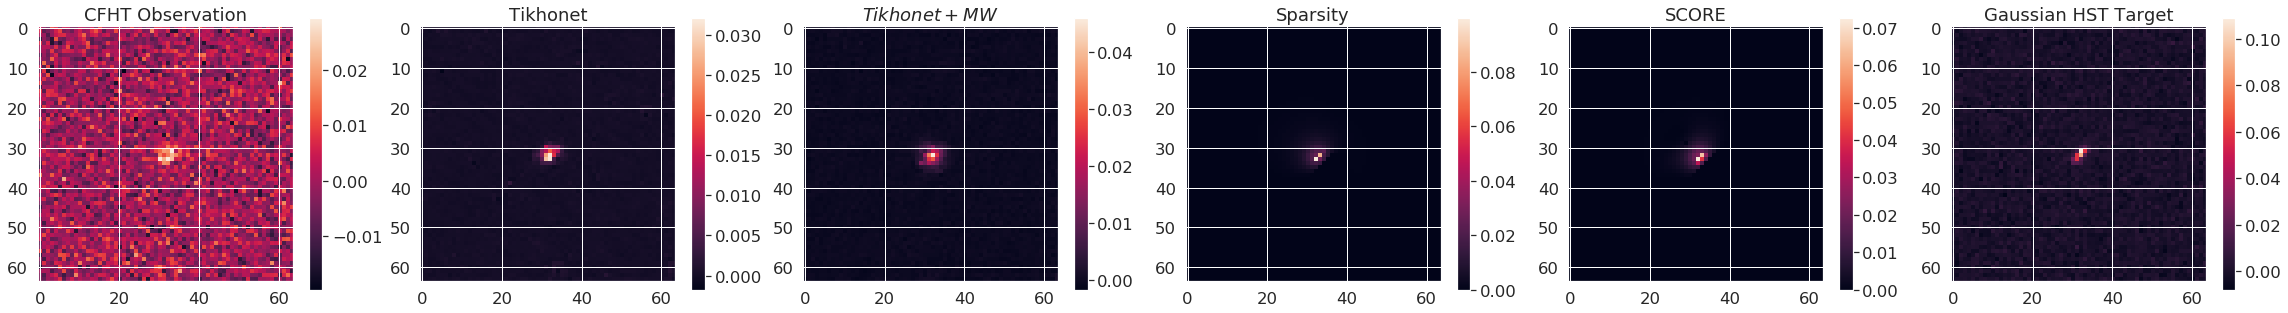

In [4]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i in range(50):#n_batch):
    plt.figure(33,figsize=(40,5))
    plt.subplot(161)
    plt.imshow(batch['inputs'][i])
    plt.title('CFHT Observation')
    plt.colorbar()
    plt.subplot(162)
    plt.imshow(res_np[i])
    plt.title(r'Tikhonet')
    plt.colorbar()
    plt.subplot(163)
    plt.imshow(res_g05_np[i])
    plt.title(r'$Tikhonet + MW$')
    plt.colorbar()
    plt.subplot(164)
    plt.imshow(score_g0[i])
    plt.title(r'Sparsity')
    plt.colorbar()
    plt.subplot(165)
    plt.imshow(score_g1[i])
    plt.title(r'SCORE')
    plt.colorbar()
    plt.subplot(166)
    plt.imshow(batch['targets'][i])
    plt.title('Gaussian HST Target')
    plt.colorbar()
    plt.show()

## Processing and Analyzing Results

### Define Error Metrics

In [5]:
U = cl.makeUi(*batch['inputs_tikho'].shape[1:3])
im_size = 64
scale = 0.1

def estimate_ell(img):
    GX = np.array([cl.scal(img,U_i) for U_i in U])
    mu20 = 0.5*(GX[3]+GX[4])-GX[0]**2/GX[2]
    mu02 = 0.5*(GX[3]-GX[4])-GX[1]**2/GX[2]
    mu11 = GX[5]-GX[0]*GX[1]/GX[2]
    e1 = (mu20-mu02)/(mu20+mu02)
    e2 = 2*(mu11)/(mu20+mu02)
    e = np.array([e1,e2])
    return e

def EllipticalGaussian(e1, e2, sig, xc=im_size//2, yc=im_size//2, stamp_size=(im_size,im_size)):
    # compute centered grid
    ranges = np.array([np.arange(i) for i in stamp_size])
    x = np.outer(ranges[0] - xc, np.ones(stamp_size[1]))
    y = np.outer(np.ones(stamp_size[0]),ranges[1] - yc)
    # shift it to match centroid
    xx = (1-e1/2)*x - e2/2*y
    yy = (1+e1/2)*y - e2/2*x
    # compute elliptical gaussian
    return np.exp(-(xx ** 2 + yy ** 2) / (2 * sig ** 2))

def relative_mse(solution, ground_truth):
    relative_mse = ((solution-ground_truth)**2).mean()/ \
                         (ground_truth**2).mean()
    return relative_mse



def get_KSB_ell(image,psf):
    error_flag = True
    #create a galsim version of the data
    image_galsim = Image(image,scale=scale)
    psf_galsim = Image(psf,scale=scale)
    #estimate the moments of the observation image
    ell=galsim.hsm.EstimateShear(image_galsim
                                 ,psf_galsim,shear_est='KSB'
                                 ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                 ,strict=False)
    if ell.error_message != '':
        error_flag = False
    return ell#,error_flag

def get_KSB_g(images,psfs):
    g_list,error_flag_list=[],[]
    for image,psf in zip(images,psfs):
        error_flag = True
        #create a galsim version of the data
        image_galsim = galsim.Image(image,scale=scale)
        # CHECK ADAPTIVE MOMENTS
        psf_galsim = galsim.Image(psf,scale=scale)
        #estimate the moments of the observation image
        shape = galsim.hsm.EstimateShear(image_galsim
                                         ,psf_galsim,shear_est='KSB'
                                         ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                         ,strict=False)
        g = np.array([shape.corrected_g1, shape.corrected_g2])
#        g = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
        if shape.error_message:# or np.linalg.norm(shape.corrected_g1+shape.corrected_g2*1j)>1:
            error_flag = False
        error_flag_list += [error_flag]
        g_list += [g]
    return np.array(g_list).T,np.array(error_flag_list)

def get_moments(images, bool_window=False):
    g_list,error_flag_list=[],[]
    if bool_window:
        window_list = []
        window_flag_list = []
    for image in images:
        error_flag = True
        #create a galsim version of the data
        image_galsim = galsim.Image(image,scale=scale)
        #estimate the moments of the observation image
        shape = galsim.hsm.FindAdaptiveMom(image_galsim
                                         ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                         ,strict=False)
        if bool_window:
            k_sigma = 3 #scale up the size of the Gaussian window to make it able to capture more useful signal
            window = EllipticalGaussian(-1.*shape.observed_shape.e1, shape.observed_shape.e2 #convention fix:
                                                                                             #e1 sign swap
                                 ,shape.moments_sigma*k_sigma # convention fix: swap x and y and origin at (0,0)
                                 ,shape.moments_centroid.y-1, shape.moments_centroid.x-1
                                 ,image.shape)
            window_flag = bool(shape.moments_status+1)
        g = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
        if shape.error_message:# or np.linalg.norm(shape.corrected_g1+shape.corrected_g2*1j)>1:
            error_flag = False
        error_flag_list += [error_flag]
        g_list += [g]
        if bool_window:
            window_list += [window]
            window_flag_list += [window_flag]
    output = [np.array(g_list).T,np.array(error_flag_list)]
    if bool_window:
        output += [np.array([window_list])[0],np.array([window_flag_list])[0]]
    return output

def g_to_e(g1,g2):
    shear = galsim.Shear(g1=g1,g2=g2)
    ell = -shear.e1, shear.e2 #reverse the signe of e_1 to get our conventions
    return ell

def MSE(X1,X2,norm=False):
    #Computes the relative MSE
    temp = 1
    if norm:
        temp = np.mean(X2**2)
    return np.mean((X1-X2)**2)/temp

def MSE_obj(obj1,obj2,norm=False):
    return np.array([MSE(o1,o2,norm) for o1,o2 in zip(obj1,obj2)])

### Estimate Unwindowed Ellipticities, KSB shear and Adaptive Moments

In [6]:
ell_g0 = np.array([estimate_ell(gal) for gal in res_np]).T
ell_s0 = np.array([estimate_ell(gal) for gal in score_g0]).T
ell_s1 = np.array([estimate_ell(gal) for gal in score_g1]).T
ell_g05 = np.array([estimate_ell(gal) for gal in res_g05_np]).T
ell_hst = np.array([estimate_ell(gal) for gal in batch['targets']]).T

ksb_g0,_ = get_KSB_g(res_np,psf_tile_hst)
ksb_s0,_ = get_KSB_g(score_g0,psf_tile_hst)
ksb_s1,_ = get_KSB_g(score_g1,psf_tile_hst)
ksb_g05,_ = get_KSB_g(res_g05_np,psf_tile_hst)
ksb_hst,_ = get_KSB_g(batch['targets'],psf_tile_hst)

mom_g0,_ = get_moments(res_np)
mom_s0,_ = get_moments(score_g0)
mom_s1,_ = get_moments(score_g1)
mom_g05,_ = get_moments(res_g05_np)
mom_hst,_,windows, window_flags = get_moments(batch['targets'],bool_window=True)

### Estimate Moments and Absolute Pixel Errors

In [7]:
# compute pixel errors
mse_g0 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_np)])
mse_s0 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], score_g0)])
mse_s1 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], score_g1)])
mse_g05 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g05_np)])

# # compute relative pixel errors
# mse_g0 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_np)])
# mse_s0 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], score_g0)])
# mse_s1 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], score_g1)])
# mse_g05 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g05_np)])

# compute winodwed pixel errors
mse_g0_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_np,windows)])
mse_s0_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], score_g0,windows)])
mse_s1_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], score_g1,windows)])
mse_g05_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g05_np,windows)])

# # compute winodwed pixel relative errors
# mse_g0_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_np,windows)])
# mse_s0_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], score_g0,windows)])
# mse_s1_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], score_g1,windows)])
# mse_g05_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g05_np,windows)])

# compute adapative moments errors
mom_err_g0 = mom_g0-mom_hst
mom_err_s0 = mom_s0-mom_hst
mom_err_s1 = mom_s1-mom_hst
mom_err_g05 = mom_g05-mom_hst

# # compute adapative moments relative errors
# mom_err_g0 = (mom_g0-mom_hst)/mom_hst
# mom_err_s0 = (mom_s0-mom_hst)/mom_hst
# mom_err_s1 = (mom_s1-mom_hst)/mom_hst
# mom_err_g05 = (mom_g05-mom_hst)/mom_hst

#compute ellipticity errors
ell_err_g0 = ell_g0 - ell_hst
ell_err_s0 = ell_s0 - ell_hst
ell_err_s1 = ell_s1 - ell_hst
ell_err_g05 = ell_g05 - ell_hst

# #compute ellipticity relative errors
# ell_err_g0 = (ell_g0 - ell_hst)/ell_hst
# ell_err_s0 = (ell_s0 - ell_hst)/ell_hst
# ell_err_s1 = (ell_s1 - ell_hst)/ell_hst
# ell_err_g05 = (ell_g05 - ell_hst)/ell_hst

### Compute Errors per Bin

In [8]:
label_s0 = r'Sparsity'
label_s1 = r'SCORE'
label_g0 = r'Tikhonet'
label_g05 = r'Tikhonet + MW'

color_g0 = 'green'
color_g05 = 'darkgreen'
color_s0 = 'blue'
color_s1 = 'darkblue'

## Warning: Window Estimation Failures Are Filtered

As shown in the cell below, one third of the window estimation fail. As a first approach we tackle this problem by removing the failures from the analyzed data. 

In [9]:
print('Proportion of failed window estimations: {}'.format(1-window_flags.sum()/window_flags.size))

Proportion of failed window estimations: 0.34342447916666663


### Computing Errors

In [10]:
# Filter the data
original_indices = np.arange(window_flags.size)[window_flags]

# compute pixel errors
mse_g0_win = mse_g0[window_flags]
mse_s1_win = mse_s1[window_flags]
mse_s0_win = mse_s0[window_flags]
mse_g05_win = mse_g05[window_flags]

# compute winodwed relative pixel errors
mse_g0_win_w = mse_g0_w[window_flags]
mse_s1_win_w = mse_s1_w[window_flags]
mse_s0_win_w = mse_s0_w[window_flags]
mse_g05_win_w = mse_g05_w[window_flags]

# compute adapative moments errors
mom_err_g0_win = mom_err_g0[:,window_flags]
mom_err_s1_win = mom_err_s1[:,window_flags]
mom_err_s0_win = mom_err_s0[:,window_flags]
mom_err_g05_win = mom_err_g05[:,window_flags]

# compute ellipticity errors
ell_err_g0_win = ell_err_g0[:,window_flags]
ell_err_s1_win = ell_err_s1[:,window_flags]
ell_err_s0_win = ell_err_s0[:,window_flags]
ell_err_g05_win = ell_err_g05[:,window_flags]


# MAKING MAG BINS
# Binning parameters
n_bins = 4
lower_bound = np.min(batch['mag_auto'][window_flags])
mag_quantiles = []
mag_means =[]

# computing mean and standard deviation of adapative moments error per binned magnitude

mom_mean_g0 = []
mom_mean_s1 = []
mom_mean_s0 = []
mom_mean_g05 = []

mom_std_g0 = []
mom_std_s1 = []
mom_std_s0 = []
mom_std_g05 = []

# computing mean and standard deviation of ellipticity error per binned magnitude

ell_mean_g0 = []
ell_mean_s1 = []
ell_mean_s0 = []
ell_mean_g05 = []

ell_std_g0 = []
ell_std_s1 = []
ell_std_s0 = []
ell_std_g05 = []

# computing mean and standard deviation of relative mse error per binned magnitude

mse_mean_g0 = []
mse_mean_s1 = []
mse_mean_s0 = []
mse_mean_g05 = []

mse_std_g0 = []
mse_std_s1 = []
mse_std_s0 = []
mse_std_g05 = []

mse_mean_g0_w = []
mse_mean_s1_w = []
mse_mean_s0_w = []
mse_mean_g05_w = []

mse_std_g0_w = []
mse_std_s1_w = []
mse_std_s0_w = []
mse_std_g05_w = []

for i in range(n_bins-1):
    q = np.quantile(batch['mag_auto'][window_flags],(i+1)/n_bins)
    ind = np.logical_and(lower_bound<=batch['mag_auto'][window_flags],batch['mag_auto'][window_flags]<q)
    mag_quantiles += [q]
    mag_means += [np.mean(batch['mag_auto'][window_flags][ind])]
    lower_bound = q
    mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_mean_s1 += [np.mean(np.abs(mom_err_s1_win[:,ind]),axis=1)]
    mom_mean_s0 += [np.mean(np.abs(mom_err_s0_win[:,ind]),axis=1)]
    mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

    mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_std_s1 += [np.std(np.abs(mom_err_s1_win[:,ind]),axis=1)]
    mom_std_s0 += [np.std(np.abs(mom_err_s0_win[:,ind]),axis=1)]
    mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]
    
    ell_mean_g0 += [np.mean(np.abs(ell_err_g0_win[:,ind]),axis=1)]
    ell_mean_s1 += [np.mean(np.abs(ell_err_s1_win[:,ind]),axis=1)]
    ell_mean_s0 += [np.mean(np.abs(ell_err_s0_win[:,ind]),axis=1)]
    ell_mean_g05 += [np.mean(np.abs(ell_err_g05_win[:,ind]),axis=1)]

    ell_std_g0 += [np.std(np.abs(ell_err_g0_win[:,ind]),axis=1)]
    ell_std_s1 += [np.std(np.abs(ell_err_s1_win[:,ind]),axis=1)]
    ell_std_s0 += [np.std(np.abs(ell_err_s0_win[:,ind]),axis=1)]
    ell_std_g05 += [np.std(np.abs(ell_err_g05_win[:,ind]),axis=1)]
    
    mse_mean_g0 += [np.mean(mse_g0_win[ind])]
    mse_mean_s1 += [np.mean(mse_s1_win[ind])]
    mse_mean_s0 += [np.mean(mse_s0_win[ind])]
    mse_mean_g05 += [np.mean(mse_g05_win[ind])]

    mse_std_g0 += [np.std(mse_g0_win[ind])]
    mse_std_s1 += [np.std(mse_s1_win[ind])]
    mse_std_s0 += [np.std(mse_s0_win[ind])]
    mse_std_g05 += [np.std(mse_g05_win[ind])]
    
    mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
    mse_mean_s1_w += [np.mean(mse_s1_win_w[ind])]
    mse_mean_s0_w += [np.mean(mse_s0_win_w[ind])]
    mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

    mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
    mse_std_s1_w += [np.std(mse_s1_win_w[ind])]
    mse_std_s0_w += [np.std(mse_s0_win_w[ind])]
    mse_std_g05_w += [np.std(mse_g05_win_w[ind])]
    
# LAST BIN BEGIN
ind = lower_bound<=batch['mag_auto'][window_flags]
mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_mean_s1 += [np.mean(np.abs(mom_err_s1_win[:,ind]),axis=1)]
mom_mean_s0 += [np.mean(np.abs(mom_err_s0_win[:,ind]),axis=1)]
mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_std_s1 += [np.std(np.abs(mom_err_s1_win[:,ind]),axis=1)]
mom_std_s0 += [np.std(np.abs(mom_err_s0_win[:,ind]),axis=1)]
mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]

ell_mean_g0 += [np.mean(np.abs(ell_err_g0_win[:,ind]),axis=1)]
ell_mean_s1 += [np.mean(np.abs(ell_err_s1_win[:,ind]),axis=1)]
ell_mean_s0 += [np.mean(np.abs(ell_err_s0_win[:,ind]),axis=1)]
ell_mean_g05 += [np.mean(np.abs(ell_err_g05_win[:,ind]),axis=1)]

ell_std_g0 += [np.std(np.abs(ell_err_g0_win[:,ind]),axis=1)]
ell_std_s1 += [np.std(np.abs(ell_err_s1_win[:,ind]),axis=1)]
ell_std_s0 += [np.std(np.abs(ell_err_s0_win[:,ind]),axis=1)]
ell_std_g05 += [np.std(np.abs(ell_err_g05_win[:,ind]),axis=1)]

mse_mean_g0 += [np.mean(mse_g0_win[ind])]
mse_mean_s1 += [np.mean(mse_s1_win[ind])]
mse_mean_s0 += [np.mean(mse_s0_win[ind])]
mse_mean_g05 += [np.mean(mse_g05_win[ind])]

mse_std_g0 += [np.std(mse_g0_win[ind])]
mse_std_s1 += [np.std(mse_s1_win[ind])]
mse_std_s0 += [np.std(mse_s0_win[ind])]
mse_std_g05 += [np.std(mse_g05_win[ind])]

mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
mse_mean_s1_w += [np.mean(mse_s1_win_w[ind])]
mse_mean_s0_w += [np.mean(mse_s0_win_w[ind])]
mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
mse_std_s1_w += [np.std(mse_s1_win_w[ind])]
mse_std_s0_w += [np.std(mse_s0_win_w[ind])]
mse_std_g05_w += [np.std(mse_g05_win_w[ind])]

# LAST BIN END
    
# Convert to numpy array with shape (2, n_bins)

mom_mean_g0 = np.array(mom_mean_g0).T
mom_mean_s1 = np.array(mom_mean_s1).T
mom_mean_s0 = np.array(mom_mean_s0).T
mom_mean_g05 = np.array(mom_mean_g05).T

mom_std_g0 = np.array(mom_std_g0).T
mom_std_s1 = np.array(mom_std_s1).T
mom_std_s0 = np.array(mom_std_s0).T
mom_std_g05 = np.array(mom_std_g05).T

ell_mean_g0 = np.array(ell_mean_g0).T
ell_mean_s1 = np.array(ell_mean_s1).T
ell_mean_s0 = np.array(ell_mean_s0).T
ell_mean_g05 = np.array(ell_mean_g05).T

ell_std_g0 = np.array(ell_std_g0).T
ell_std_s1 = np.array(ell_std_s1).T
ell_std_s0 = np.array(ell_std_s0).T
ell_std_g05 = np.array(ell_std_g05).T

mse_mean_g0 = np.array(mse_mean_g0).T
mse_mean_s1 = np.array(mse_mean_s1).T
mse_mean_s0 = np.array(mse_mean_s0).T
mse_mean_g05 = np.array(mse_mean_g05).T

mse_std_g0 = np.array(mse_std_g0).T
mse_std_s1 = np.array(mse_std_s1).T
mse_std_s0 = np.array(mse_std_s0).T
mse_std_g05 = np.array(mse_std_g05).T

mse_mean_g0_w = np.array(mse_mean_g0_w).T
mse_mean_s1_w = np.array(mse_mean_s1_w).T
mse_mean_s0_w = np.array(mse_mean_s0_w).T
mse_mean_g05_w = np.array(mse_mean_g05_w).T

mse_std_g0_w = np.array(mse_std_g0_w).T
mse_std_s1_w = np.array(mse_std_s1_w).T
mse_std_s0_w = np.array(mse_std_s0_w).T
mse_std_g05_w = np.array(mse_std_g05_w).T

In [11]:
# BEGIN BINNING
# Partition galaxies into bins of equal size
# Initialize lower bound
lower_bound = np.min(batch['mag_auto'][window_flags])
gal_sum = 0
bins = []

sqrt_num_gal = [] # conversion factor of standard deviation to mean error standard deviation

for i in range(n_bins-1):
    # compute quantile that is used as an upper bound
    q = np.quantile(batch['mag_auto'][window_flags],(i+1)/n_bins)
    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=batch['mag_auto'][window_flags],batch['mag_auto'][window_flags]<q)
    # retrieve corresponding objects
    mag_q = batch['mag_auto'][window_flags][cond]
    print(i+1, q, np.mean(mag_q))
    bins += [np.mean(mag_q)]
    # compute the square root of the bin size
    sqrt_num_gal += [np.sqrt(np.sum(cond))]
    # update lower bound
    lower_bound = q
# retrieve last bin indices
cond = lower_bound<=batch['mag_auto'][window_flags]
# retrieve corresponding objects
mag_q = batch['mag_auto'][window_flags][cond]
bins += [np.mean(mag_q)]
# compute the square root of the bin size
sqrt_num_gal += [np.sqrt(np.sum(cond))]
print(i+1, q, np.mean(mag_q))

# END BINNING


1 21.718219757080078 20.793262
2 22.555931091308594 22.164833
3 23.062789916992188 22.826544
3 23.062789916992188 23.29574


### Plot $g$ vs $\text{MAG}$

In [12]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_s1[0],mom_std_s1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.errorbar(bins,mom_mean_s0[0],mom_std_s0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_{1})$')
plt.title(r'$g_1$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_s1[1],mom_std_s1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.errorbar(bins,mom_mean_s0[1],mom_std_s0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_2)$')
plt.title(r'$g_2$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

### Plot $e$ vs $\text{MAG}$

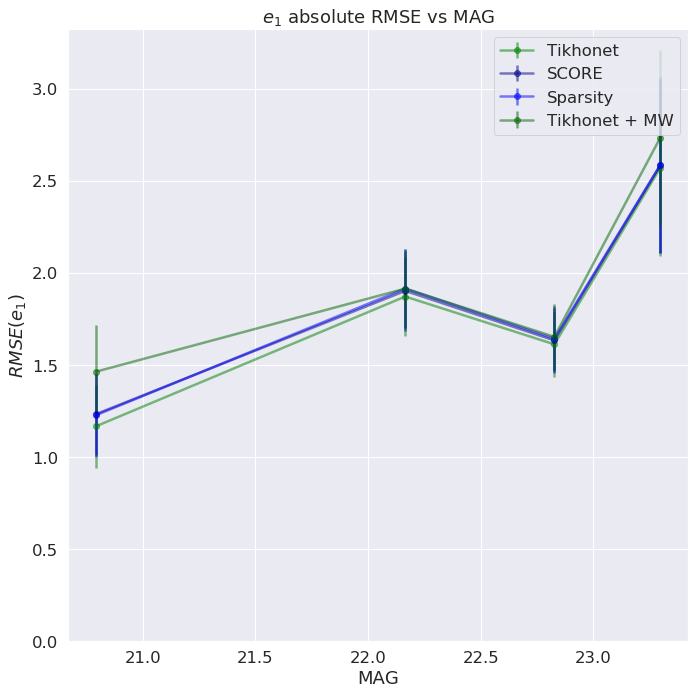

In [13]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,ell_mean_g0[0],ell_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,ell_mean_s1[0],ell_std_s1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.errorbar(bins,ell_mean_s0[0],ell_std_s0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,ell_mean_g05[0],ell_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
# plt.ylim([2*1e-1, 1.225])
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(e_{1})$')
plt.title(r'$e_1$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,ell_mean_g0[1],ell_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,ell_mean_s1[1],ell_std_s1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.errorbar(bins,ell_mean_s0[1],ell_std_s0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,ell_mean_g05[1],ell_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(e_2)$')
plt.title(r'$e_2$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

### Plot $\text{MSE}$ vs $\text{MAG}$

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


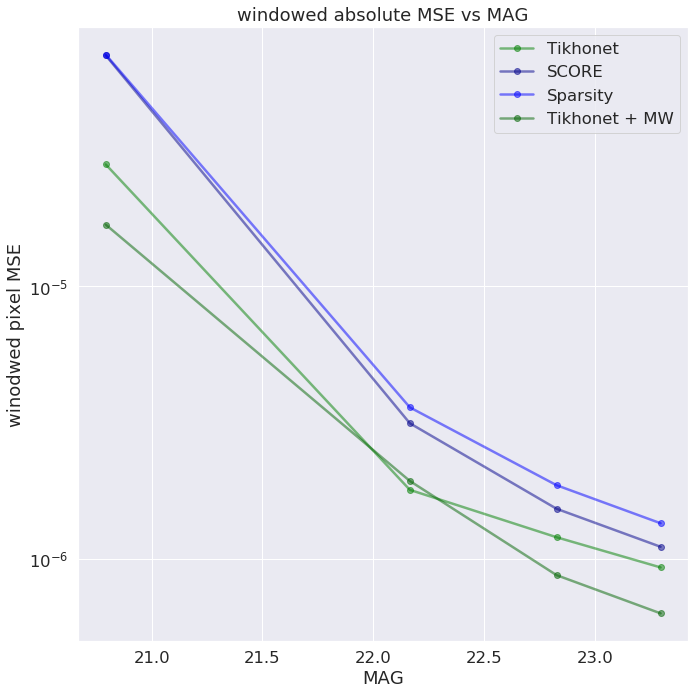

In [14]:
plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_s1,mse_std_s1/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
# plt.errorbar(bins,mse_mean_s0,mse_std_s0/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_s1,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.semilogy(bins,mse_mean_s0,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'pixel MSE')
plt.title(r'absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0_w,mse_std_g0_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_s1_w,mse_std_s1_w/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
# plt.errorbar(bins,mse_mean_s0_w,mse_std_s0_w/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05_w,mse_std_g05_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.semilogy(bins,mse_mean_g0_w,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_s1_w,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.semilogy(bins,mse_mean_s0_w,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05_w,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'winodwed pixel MSE')
plt.title(r'windowed absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

### Estimate Moments and Pixel Relative Errors

### Compute Errors per Bin

## Warning: Window Estimation Failures Are Filtered

As shown in the cell below, one third of the window estimation fail. As a first approach we tackle this problem by removing the failures from the analyzed data. 

In [15]:
# # compute pixel errors
# mse_g0 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_np)])
# mse_s0 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], score_g0)])
# mse_s1 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], score_g1)])
# mse_g05 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g05_np)])

# compute relative pixel errors
mse_g0 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_np)])
mse_s0 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], score_g0)])
mse_s1 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], score_g1)])
mse_g05 = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g05_np)])

# compute winodwed pixel errors
mse_g0_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_np,windows)])
mse_s0_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], score_g0,windows)])
mse_s1_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], score_g1,windows)])
mse_g05_w = np.array([MSE_obj(true*w,est*w) for true,est,w in zip(batch['targets'], res_g05_np,windows)])

# # compute winodwed pixel relative errors
# mse_g0_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_np,windows)])
# mse_s0_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], score_g0,windows)])
# mse_s1_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], score_g1,windows)])
# mse_g05_w = np.array([relative_mse(true*w,est*w) for true,est,w in zip(batch['targets'], res_g05_np,windows)])

# # compute adapative moments errors
# mom_err_g0 = mom_g0-mom_hst
# mom_err_s0 = mom_s0-mom_hst
# mom_err_s1 = mom_s1-mom_hst
# mom_err_g05 = mom_g05-mom_hst

# compute adapative moments relative errors
mom_err_g0 = (mom_g0-mom_hst)/mom_hst
mom_err_s0 = (mom_s0-mom_hst)/mom_hst
mom_err_s1 = (mom_s1-mom_hst)/mom_hst
mom_err_g05 = (mom_g05-mom_hst)/mom_hst

# #compute ellipticity errors
# ell_err_g0 = ell_g0 - ell_hst
# ell_err_s0 = ell_s0 - ell_hst
# ell_err_s1 = ell_s1 - ell_hst
# ell_err_g05 = ell_g05 - ell_hst

#compute ellipticity relative errors
ell_err_g0 = (ell_g0 - ell_hst)/ell_hst
ell_err_s0 = (ell_s0 - ell_hst)/ell_hst
ell_err_s1 = (ell_s1 - ell_hst)/ell_hst
ell_err_g05 = (ell_g05 - ell_hst)/ell_hst

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher

In [16]:
print('Proportion of failed window estimations: {}'.format(1-window_flags.sum()/window_flags.size))

Proportion of failed window estimations: 0.34342447916666663


### Computing Errors

In [17]:
# Filter the data
original_indices = np.arange(window_flags.size)[window_flags]

# compute pixel errors
mse_g0_win = mse_g0[window_flags]
mse_s1_win = mse_s1[window_flags]
mse_s0_win = mse_s0[window_flags]
mse_g05_win = mse_g05[window_flags]

# compute winodwed relative pixel errors
mse_g0_win_w = mse_g0_w[window_flags]
mse_s1_win_w = mse_s1_w[window_flags]
mse_s0_win_w = mse_s0_w[window_flags]
mse_g05_win_w = mse_g05_w[window_flags]

# compute adapative moments errors
mom_err_g0_win = mom_err_g0[:,window_flags]
mom_err_s1_win = mom_err_s1[:,window_flags]
mom_err_s0_win = mom_err_s0[:,window_flags]
mom_err_g05_win = mom_err_g05[:,window_flags]

# compute ellipticity errors
ell_err_g0_win = ell_err_g0[:,window_flags]
ell_err_s1_win = ell_err_s1[:,window_flags]
ell_err_s0_win = ell_err_s0[:,window_flags]
ell_err_g05_win = ell_err_g05[:,window_flags]


# MAKING MAG BINS
# Binning parameters
n_bins = 4
lower_bound = np.min(batch['mag_auto'][window_flags])
mag_quantiles = []
mag_means =[]

# computing mean and standard deviation of adapative moments error per binned magnitude

mom_mean_g0 = []
mom_mean_s1 = []
mom_mean_s0 = []
mom_mean_g05 = []

mom_std_g0 = []
mom_std_s1 = []
mom_std_s0 = []
mom_std_g05 = []

# computing mean and standard deviation of ellipticity error per binned magnitude

ell_mean_g0 = []
ell_mean_s1 = []
ell_mean_s0 = []
ell_mean_g05 = []

ell_std_g0 = []
ell_std_s1 = []
ell_std_s0 = []
ell_std_g05 = []

# computing mean and standard deviation of relative mse error per binned magnitude

mse_mean_g0 = []
mse_mean_s1 = []
mse_mean_s0 = []
mse_mean_g05 = []

mse_std_g0 = []
mse_std_s1 = []
mse_std_s0 = []
mse_std_g05 = []

mse_mean_g0_w = []
mse_mean_s1_w = []
mse_mean_s0_w = []
mse_mean_g05_w = []

mse_std_g0_w = []
mse_std_s1_w = []
mse_std_s0_w = []
mse_std_g05_w = []

for i in range(n_bins-1):
    q = np.quantile(batch['mag_auto'][window_flags],(i+1)/n_bins)
    ind = np.logical_and(lower_bound<=batch['mag_auto'][window_flags],batch['mag_auto'][window_flags]<q)
    mag_quantiles += [q]
    mag_means += [np.mean(batch['mag_auto'][window_flags][ind])]
    lower_bound = q
    mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_mean_s1 += [np.mean(np.abs(mom_err_s1_win[:,ind]),axis=1)]
    mom_mean_s0 += [np.mean(np.abs(mom_err_s0_win[:,ind]),axis=1)]
    mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

    mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_std_s1 += [np.std(np.abs(mom_err_s1_win[:,ind]),axis=1)]
    mom_std_s0 += [np.std(np.abs(mom_err_s0_win[:,ind]),axis=1)]
    mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]
    
    ell_mean_g0 += [np.mean(np.abs(ell_err_g0_win[:,ind]),axis=1)]
    ell_mean_s1 += [np.mean(np.abs(ell_err_s1_win[:,ind]),axis=1)]
    ell_mean_s0 += [np.mean(np.abs(ell_err_s0_win[:,ind]),axis=1)]
    ell_mean_g05 += [np.mean(np.abs(ell_err_g05_win[:,ind]),axis=1)]

    ell_std_g0 += [np.std(np.abs(ell_err_g0_win[:,ind]),axis=1)]
    ell_std_s1 += [np.std(np.abs(ell_err_s1_win[:,ind]),axis=1)]
    ell_std_s0 += [np.std(np.abs(ell_err_s0_win[:,ind]),axis=1)]
    ell_std_g05 += [np.std(np.abs(ell_err_g05_win[:,ind]),axis=1)]
    
    mse_mean_g0 += [np.mean(mse_g0_win[ind])]
    mse_mean_s1 += [np.mean(mse_s1_win[ind])]
    mse_mean_s0 += [np.mean(mse_s0_win[ind])]
    mse_mean_g05 += [np.mean(mse_g05_win[ind])]

    mse_std_g0 += [np.std(mse_g0_win[ind])]
    mse_std_s1 += [np.std(mse_s1_win[ind])]
    mse_std_s0 += [np.std(mse_s0_win[ind])]
    mse_std_g05 += [np.std(mse_g05_win[ind])]
    
    mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
    mse_mean_s1_w += [np.mean(mse_s1_win_w[ind])]
    mse_mean_s0_w += [np.mean(mse_s0_win_w[ind])]
    mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

    mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
    mse_std_s1_w += [np.std(mse_s1_win_w[ind])]
    mse_std_s0_w += [np.std(mse_s0_win_w[ind])]
    mse_std_g05_w += [np.std(mse_g05_win_w[ind])]
    
# LAST BIN BEGIN
ind = lower_bound<=batch['mag_auto'][window_flags]
mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_mean_s1 += [np.mean(np.abs(mom_err_s1_win[:,ind]),axis=1)]
mom_mean_s0 += [np.mean(np.abs(mom_err_s0_win[:,ind]),axis=1)]
mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_std_s1 += [np.std(np.abs(mom_err_s1_win[:,ind]),axis=1)]
mom_std_s0 += [np.std(np.abs(mom_err_s0_win[:,ind]),axis=1)]
mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]

ell_mean_g0 += [np.mean(np.abs(ell_err_g0_win[:,ind]),axis=1)]
ell_mean_s1 += [np.mean(np.abs(ell_err_s1_win[:,ind]),axis=1)]
ell_mean_s0 += [np.mean(np.abs(ell_err_s0_win[:,ind]),axis=1)]
ell_mean_g05 += [np.mean(np.abs(ell_err_g05_win[:,ind]),axis=1)]

ell_std_g0 += [np.std(np.abs(ell_err_g0_win[:,ind]),axis=1)]
ell_std_s1 += [np.std(np.abs(ell_err_s1_win[:,ind]),axis=1)]
ell_std_s0 += [np.std(np.abs(ell_err_s0_win[:,ind]),axis=1)]
ell_std_g05 += [np.std(np.abs(ell_err_g05_win[:,ind]),axis=1)]

mse_mean_g0 += [np.mean(mse_g0_win[ind])]
mse_mean_s1 += [np.mean(mse_s1_win[ind])]
mse_mean_s0 += [np.mean(mse_s0_win[ind])]
mse_mean_g05 += [np.mean(mse_g05_win[ind])]

mse_std_g0 += [np.std(mse_g0_win[ind])]
mse_std_s1 += [np.std(mse_s1_win[ind])]
mse_std_s0 += [np.std(mse_s0_win[ind])]
mse_std_g05 += [np.std(mse_g05_win[ind])]

mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
mse_mean_s1_w += [np.mean(mse_s1_win_w[ind])]
mse_mean_s0_w += [np.mean(mse_s0_win_w[ind])]
mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
mse_std_s1_w += [np.std(mse_s1_win_w[ind])]
mse_std_s0_w += [np.std(mse_s0_win_w[ind])]
mse_std_g05_w += [np.std(mse_g05_win_w[ind])]

# LAST BIN END
    
# Convert to numpy array with shape (2, n_bins)

mom_mean_g0 = np.array(mom_mean_g0).T
mom_mean_s1 = np.array(mom_mean_s1).T
mom_mean_s0 = np.array(mom_mean_s0).T
mom_mean_g05 = np.array(mom_mean_g05).T

mom_std_g0 = np.array(mom_std_g0).T
mom_std_s1 = np.array(mom_std_s1).T
mom_std_s0 = np.array(mom_std_s0).T
mom_std_g05 = np.array(mom_std_g05).T

ell_mean_g0 = np.array(ell_mean_g0).T
ell_mean_s1 = np.array(ell_mean_s1).T
ell_mean_s0 = np.array(ell_mean_s0).T
ell_mean_g05 = np.array(ell_mean_g05).T

ell_std_g0 = np.array(ell_std_g0).T
ell_std_s1 = np.array(ell_std_s1).T
ell_std_s0 = np.array(ell_std_s0).T
ell_std_g05 = np.array(ell_std_g05).T

mse_mean_g0 = np.array(mse_mean_g0).T
mse_mean_s1 = np.array(mse_mean_s1).T
mse_mean_s0 = np.array(mse_mean_s0).T
mse_mean_g05 = np.array(mse_mean_g05).T

mse_std_g0 = np.array(mse_std_g0).T
mse_std_s1 = np.array(mse_std_s1).T
mse_std_s0 = np.array(mse_std_s0).T
mse_std_g05 = np.array(mse_std_g05).T

mse_mean_g0_w = np.array(mse_mean_g0_w).T
mse_mean_s1_w = np.array(mse_mean_s1_w).T
mse_mean_s0_w = np.array(mse_mean_s0_w).T
mse_mean_g05_w = np.array(mse_mean_g05_w).T

mse_std_g0_w = np.array(mse_std_g0_w).T
mse_std_s1_w = np.array(mse_std_s1_w).T
mse_std_s0_w = np.array(mse_std_s0_w).T
mse_std_g05_w = np.array(mse_std_g05_w).T

In [18]:
# BEGIN BINNING
# Partition galaxies into bins of equal size
# Initialize lower bound
lower_bound = np.min(batch['mag_auto'][window_flags])
gal_sum = 0
bins = []

sqrt_num_gal = [] # conversion factor of standard deviation to mean error standard deviation

for i in range(n_bins-1):
    # compute quantile that is used as an upper bound
    q = np.quantile(batch['mag_auto'][window_flags],(i+1)/n_bins)
    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=batch['mag_auto'][window_flags],batch['mag_auto'][window_flags]<q)
    # retrieve corresponding objects
    mag_q = batch['mag_auto'][window_flags][cond]
    print(i+1, q, np.mean(mag_q))
    bins += [np.mean(mag_q)]
    # compute the square root of the bin size
    sqrt_num_gal += [np.sqrt(np.sum(cond))]
    # update lower bound
    lower_bound = q
# retrieve last bin indices
cond = lower_bound<=batch['mag_auto'][window_flags]
# retrieve corresponding objects
mag_q = batch['mag_auto'][window_flags][cond]
bins += [np.mean(mag_q)]
# compute the square root of the bin size
sqrt_num_gal += [np.sqrt(np.sum(cond))]
print(i+1, q, np.mean(mag_q))

# END BINNING


1 21.718219757080078 20.793262
2 22.555931091308594 22.164833
3 23.062789916992188 22.826544
3 23.062789916992188 23.29574


### Plot $g$ vs $\text{MAG}$

In [19]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_s1[0],mom_std_s1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.errorbar(bins,mom_mean_s0[0],mom_std_s0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_{1})$')
plt.title(r'$g_1$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_s1[1],mom_std_s1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.errorbar(bins,mom_mean_s0[1],mom_std_s0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(g_2)$')
plt.title(r'$g_2$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

### Plot $e$ vs $\text{MAG}$

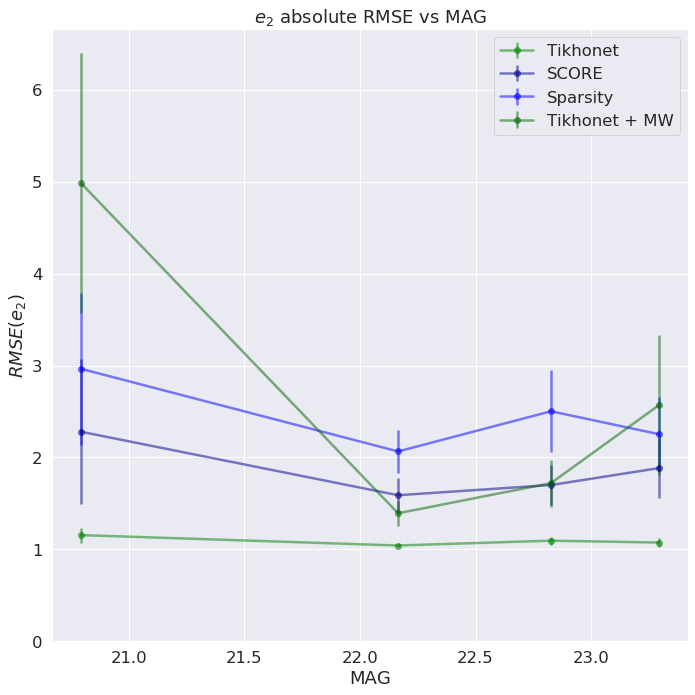

In [20]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,ell_mean_g0[0],ell_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,ell_mean_s1[0],ell_std_s1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.errorbar(bins,ell_mean_s0[0],ell_std_s0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,ell_mean_g05[0],ell_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
# plt.ylim([2*1e-1, 1.225])
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(e_{1})$')
plt.title(r'$e_1$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,ell_mean_g0[1],ell_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,ell_mean_s1[1],ell_std_s1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.errorbar(bins,ell_mean_s0[1],ell_std_s0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,ell_mean_g05[1],ell_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'$RMSE(e_2)$')
plt.title(r'$e_2$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

### Plot $\text{MSE}$ vs $\text{MAG}$

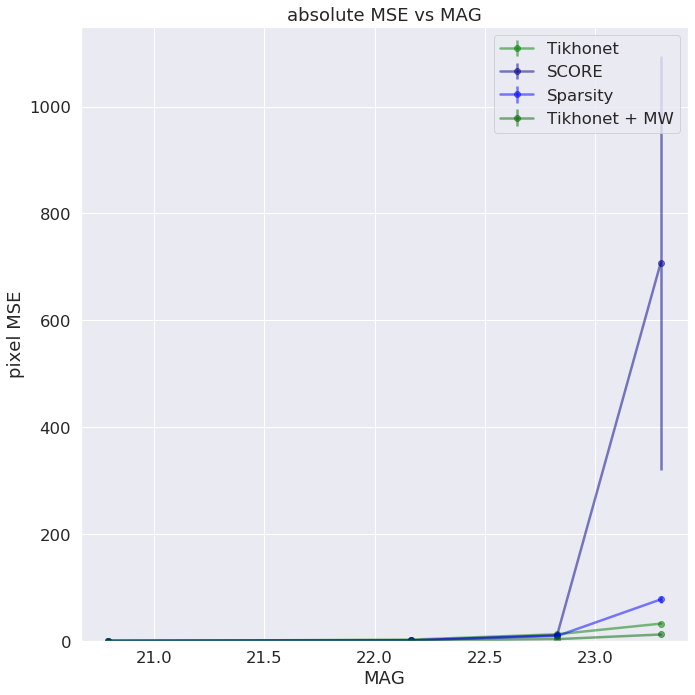

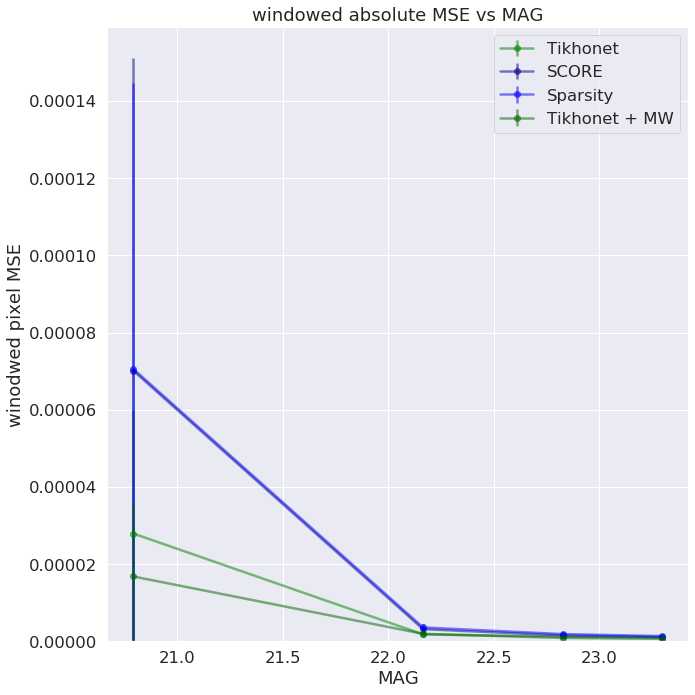

In [21]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_s1,mse_std_s1/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.errorbar(bins,mse_mean_s0,mse_std_s0/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
# plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_s1,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
# plt.semilogy(bins,mse_mean_s0,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g1,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'pixel MSE')
plt.title(r'absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0_w,mse_std_g0_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_s1_w,mse_std_s1_w/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
plt.errorbar(bins,mse_mean_s0_w,mse_std_s0_w/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mse_mean_g05_w,mse_std_g05_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
# plt.semilogy(bins,mse_mean_g0_w,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_s1_w,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.5)
# plt.semilogy(bins,mse_mean_s0_w,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05_w,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.5)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'winodwed pixel MSE')
plt.title(r'windowed absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()